In [32]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
from random import seed
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pickle
import torch.nn as nn
import math

In [33]:
np.random.seed(123)
seed(123)
torch.manual_seed(123)
def get_unique_probs(x):
    uniqueids = np.ascontiguousarray(x).view(np.dtype((np.void, x.dtype.itemsize * x.shape[1])))
    _, unique_inverse, unique_counts = np.unique(uniqueids, return_index=False, return_inverse=True, return_counts=True)
    return np.asarray(unique_counts / float(sum(unique_counts))), unique_inverse

def bin_calc_information(labelixs, layerdata, binsize):
    nats2bits = 1.0 / np.log(2)

    def get_h(d):
        digitized = np.floor(d / binsize).astype('int')
        p_ts, _ = get_unique_probs(digitized)
        return -np.sum(p_ts * np.log(p_ts))

    H_LAYER = get_h(layerdata)
    H_LAYER_GIVEN_OUTPUT = 0
    for label, ixs in labelixs.items():
        h = get_h(layerdata[ixs])
        H_LAYER_GIVEN_OUTPUT += ixs.mean() * h
    return nats2bits * H_LAYER, nats2bits * (H_LAYER - H_LAYER_GIVEN_OUTPUT)

# 定义 MNIST 数据集类
class MNIST(datasets.MNIST):
    def __init__(self, root, train=True, download=False, randomize=False):
        super(MNIST, self).__init__(root, train, download=True)  # Ensure download is True
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.targets = self.targets.to(device)
        self.data = self.data / 255.0
        self.data = self.data.view(-1, 28 * 28).to(device)

        if randomize:
            idx_rnd = torch.randperm(len(self.targets))
            self.targets = self.targets[idx_rnd]

    def __getitem__(self, index):
        img, targets = self.data[index], self.targets[index]
        return img, targets

# 定义神经网络
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(784, 1024)
        self.fc2 = torch.nn.Linear(1024, 20)
        self.fc3 = torch.nn.Linear(20, 20)
        self.fc4 = torch.nn.Linear(20, 20)
        self.fc5 = torch.nn.Linear(20, 10)

    def forward(self, x):
        activations = []
        x = x.view(-1, 784)
        x = torch.tanh(self.fc1(x))
        activations.append(x.cpu().data.numpy())  # 将激活值移动到 CPU 上
        x = torch.tanh(self.fc2(x))
        activations.append(x.cpu().data.numpy())  # 将激活值移动到 CPU 上
        x = torch.tanh(self.fc3(x))
        activations.append(x.cpu().data.numpy())  # 将激活值移动到 CPU 上
        x = torch.tanh(self.fc4(x))
        activations.append(x.cpu().data.numpy())  # 将激活值移动到 CPU 上
        x = torch.softmax(self.fc5(x), dim=1)  # 添加dim参数以指定 softmax 在哪个维度上操作
        activations.append(x.cpu().data.numpy())  # 将激活值移动到 CPU 上
        return x, activations

to device: cuda
Epoch    0 train: loss 2.3030 - acc 0.1052
Epoch    0 test: loss 2.2959 - acc 0.2451
Epoch    1 train: loss 2.2961 - acc 0.2352
Epoch    1 test: loss 2.2895 - acc 0.3637
Epoch    2 train: loss 2.2898 - acc 0.3501
Epoch    2 test: loss 2.2832 - acc 0.3983
Epoch    3 train: loss 2.2837 - acc 0.3936
Epoch    3 test: loss 2.2776 - acc 0.4493
Epoch    4 train: loss 2.2781 - acc 0.4476
Epoch    4 test: loss 2.2728 - acc 0.4615
Epoch    5 train: loss 2.2733 - acc 0.4597
Epoch    5 test: loss 2.2685 - acc 0.4650
Epoch    6 train: loss 2.2690 - acc 0.4629
Epoch    6 test: loss 2.2644 - acc 0.4668
Epoch    7 train: loss 2.2650 - acc 0.4649
Epoch    7 test: loss 2.2607 - acc 0.4695
Epoch    8 train: loss 2.2612 - acc 0.4685
Epoch    8 test: loss 2.2572 - acc 0.4732
Epoch    9 train: loss 2.2577 - acc 0.4731
Epoch    9 test: loss 2.2539 - acc 0.4780
Epoch   10 train: loss 2.2544 - acc 0.4775
Epoch   10 test: loss 2.2507 - acc 0.4827
Epoch   11 train: loss 2.2512 - acc 0.4827
Epoch 

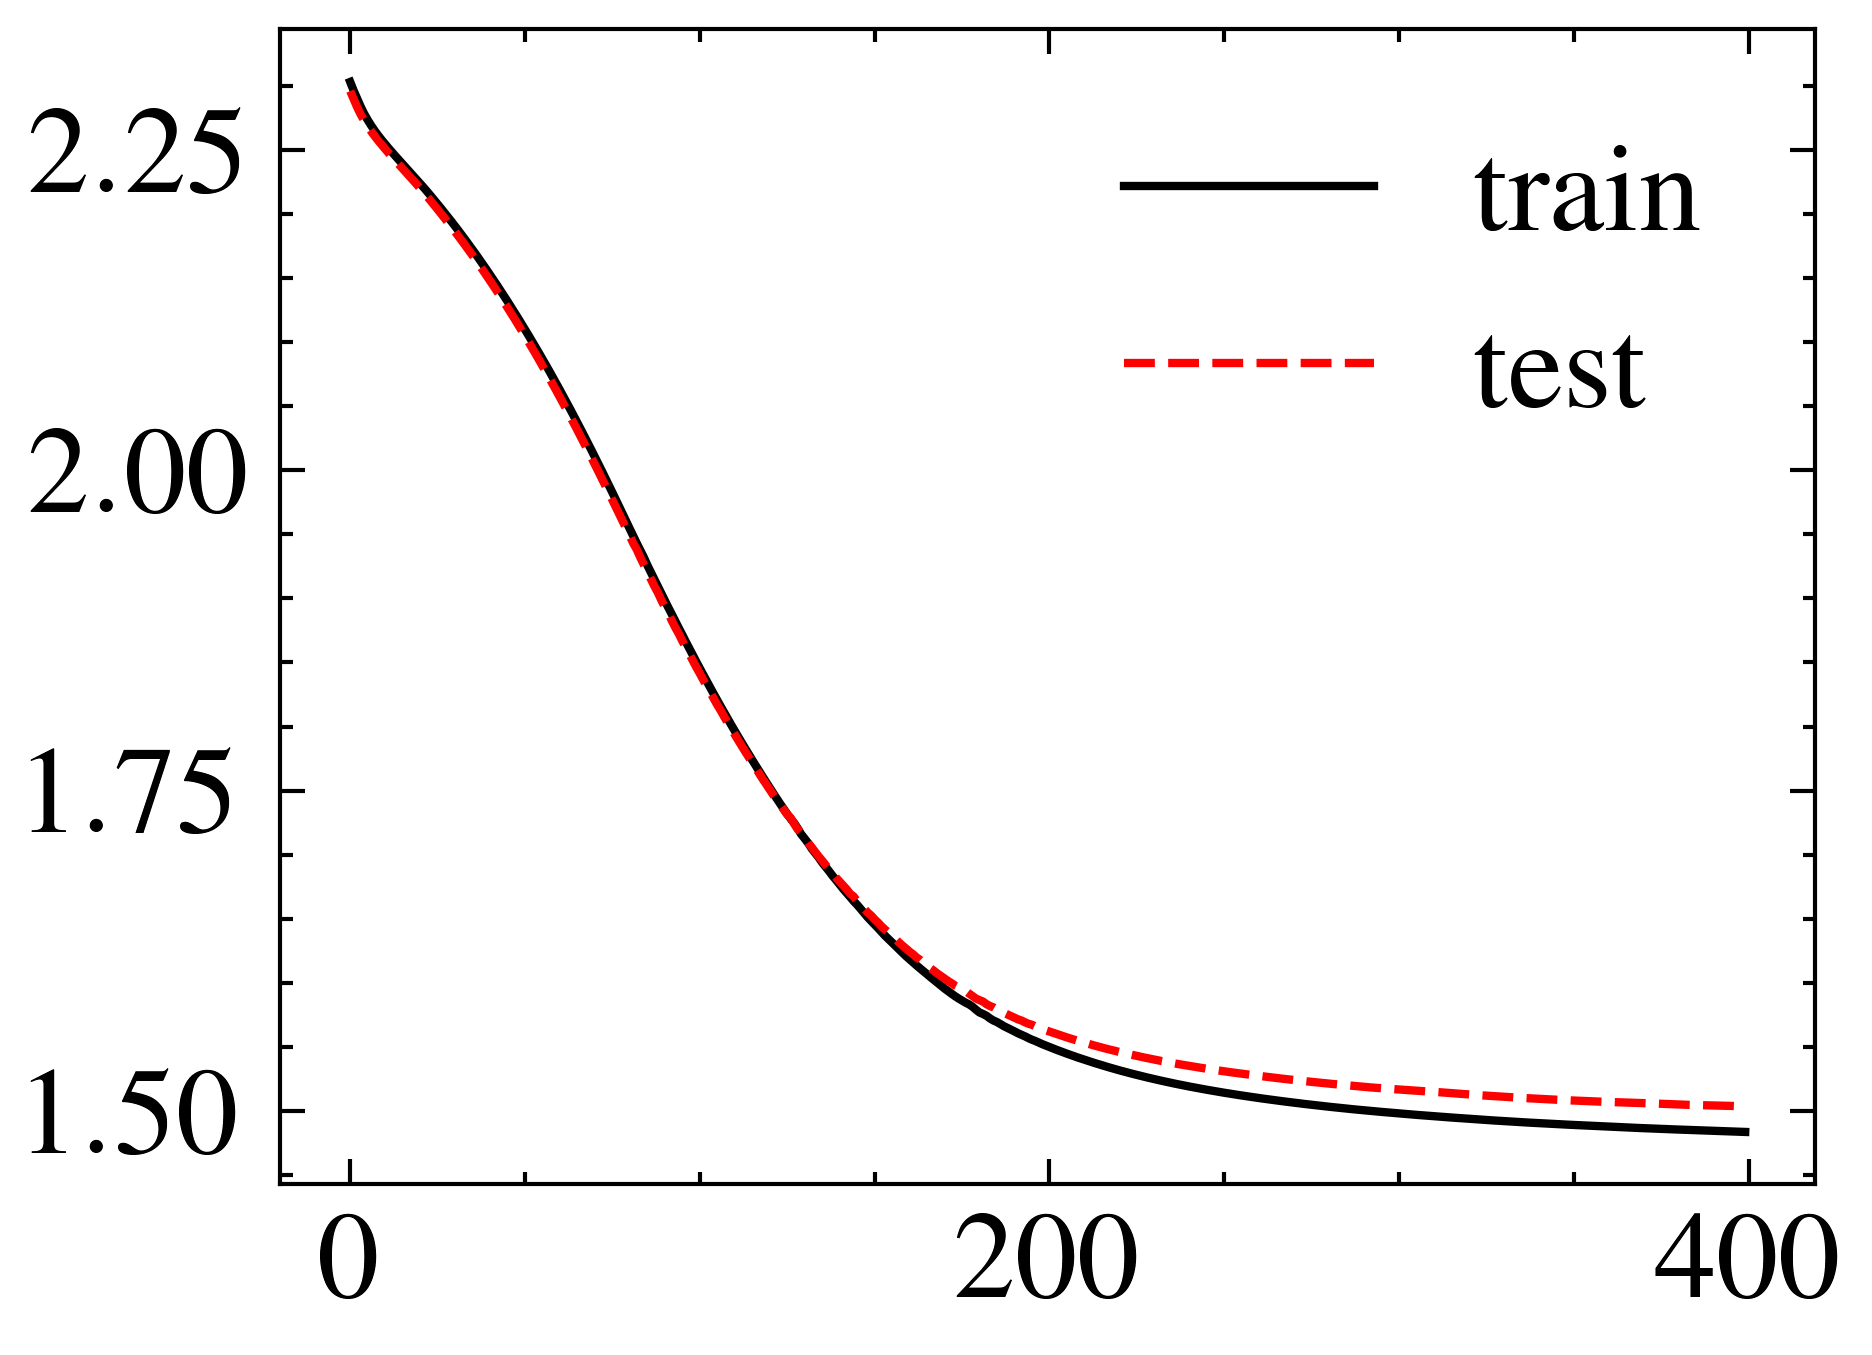

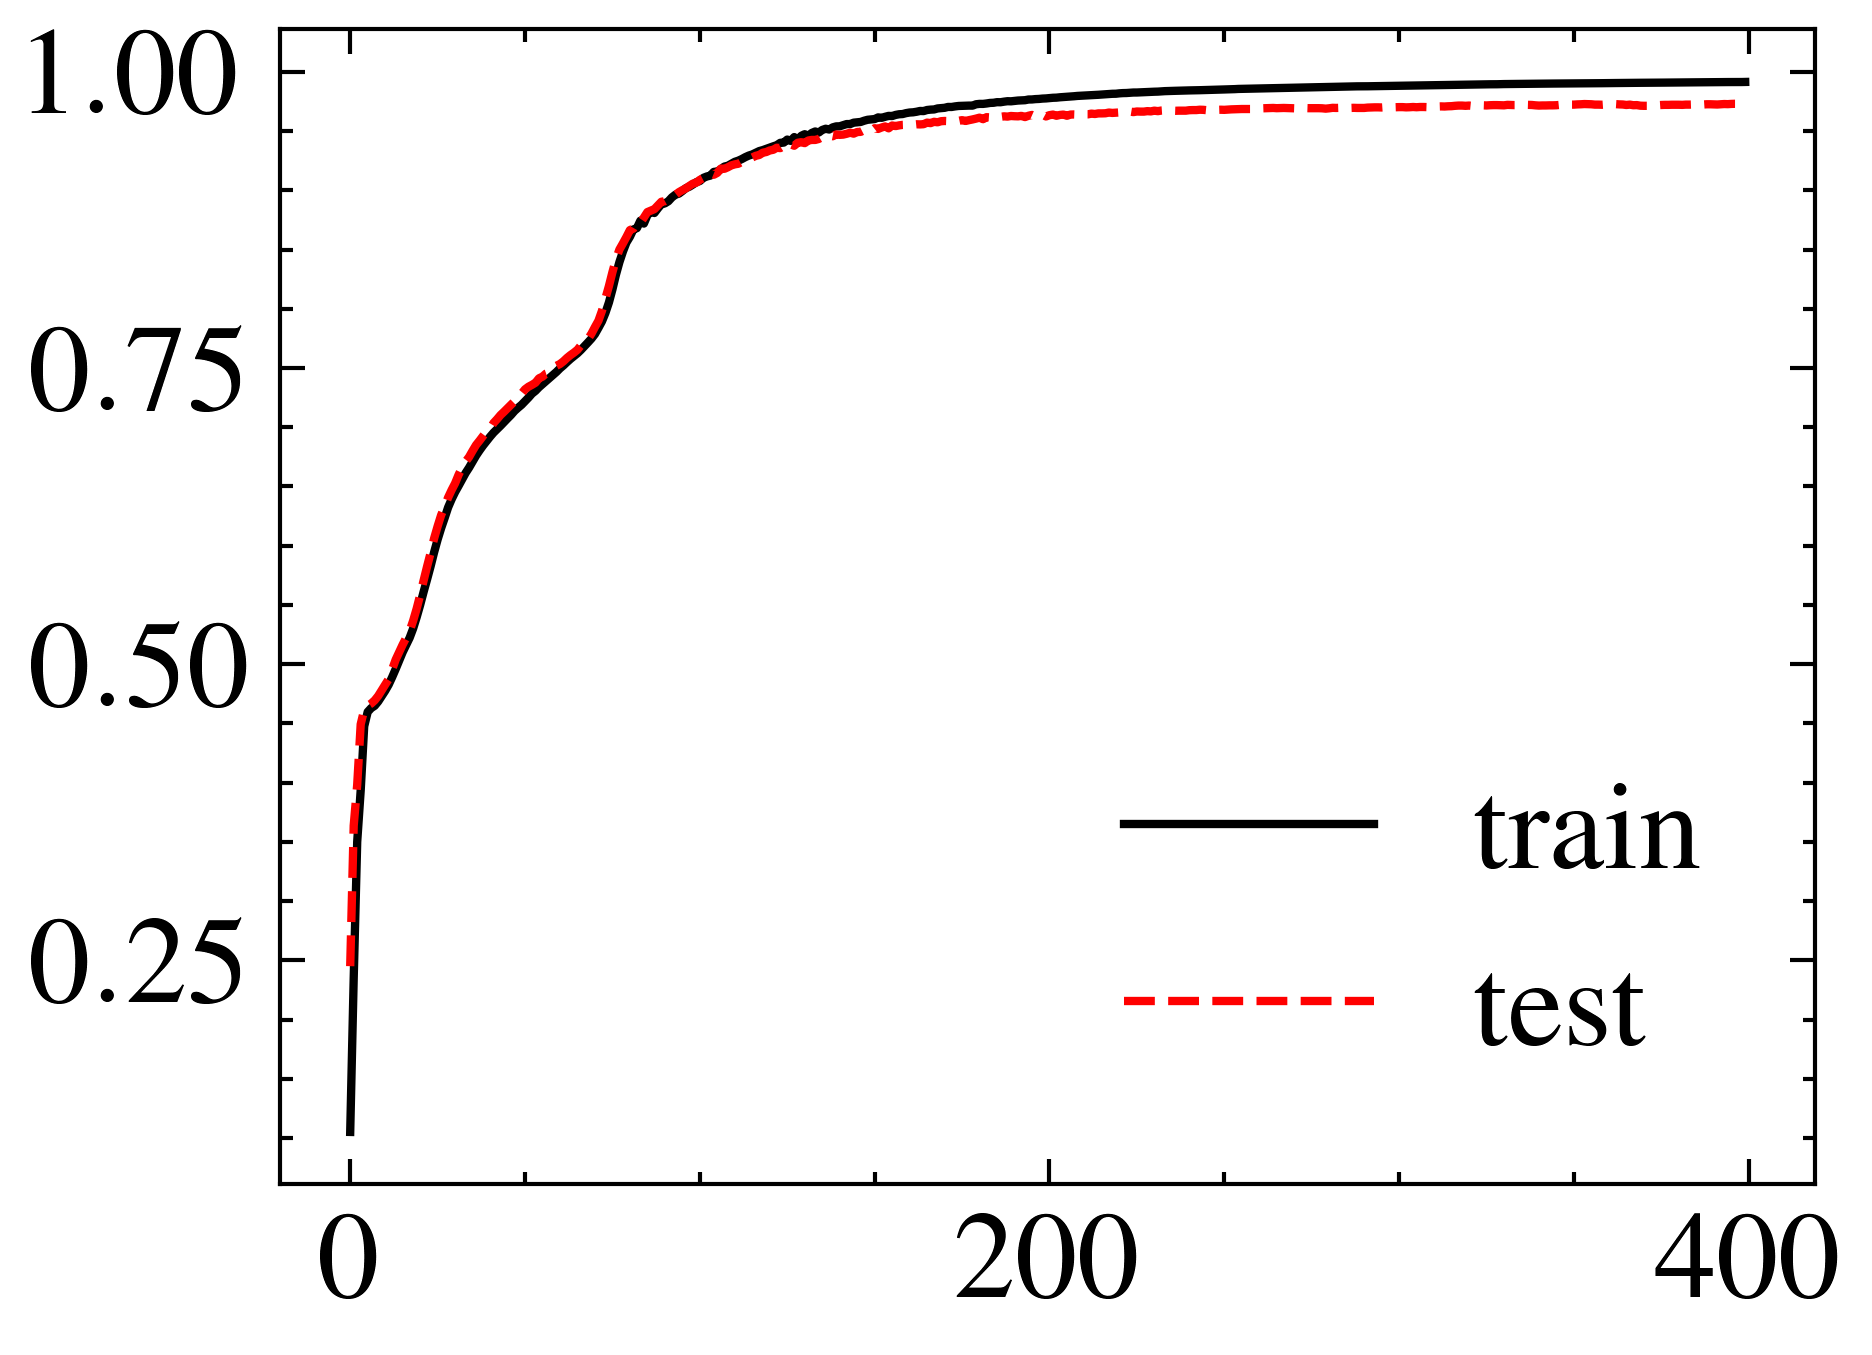

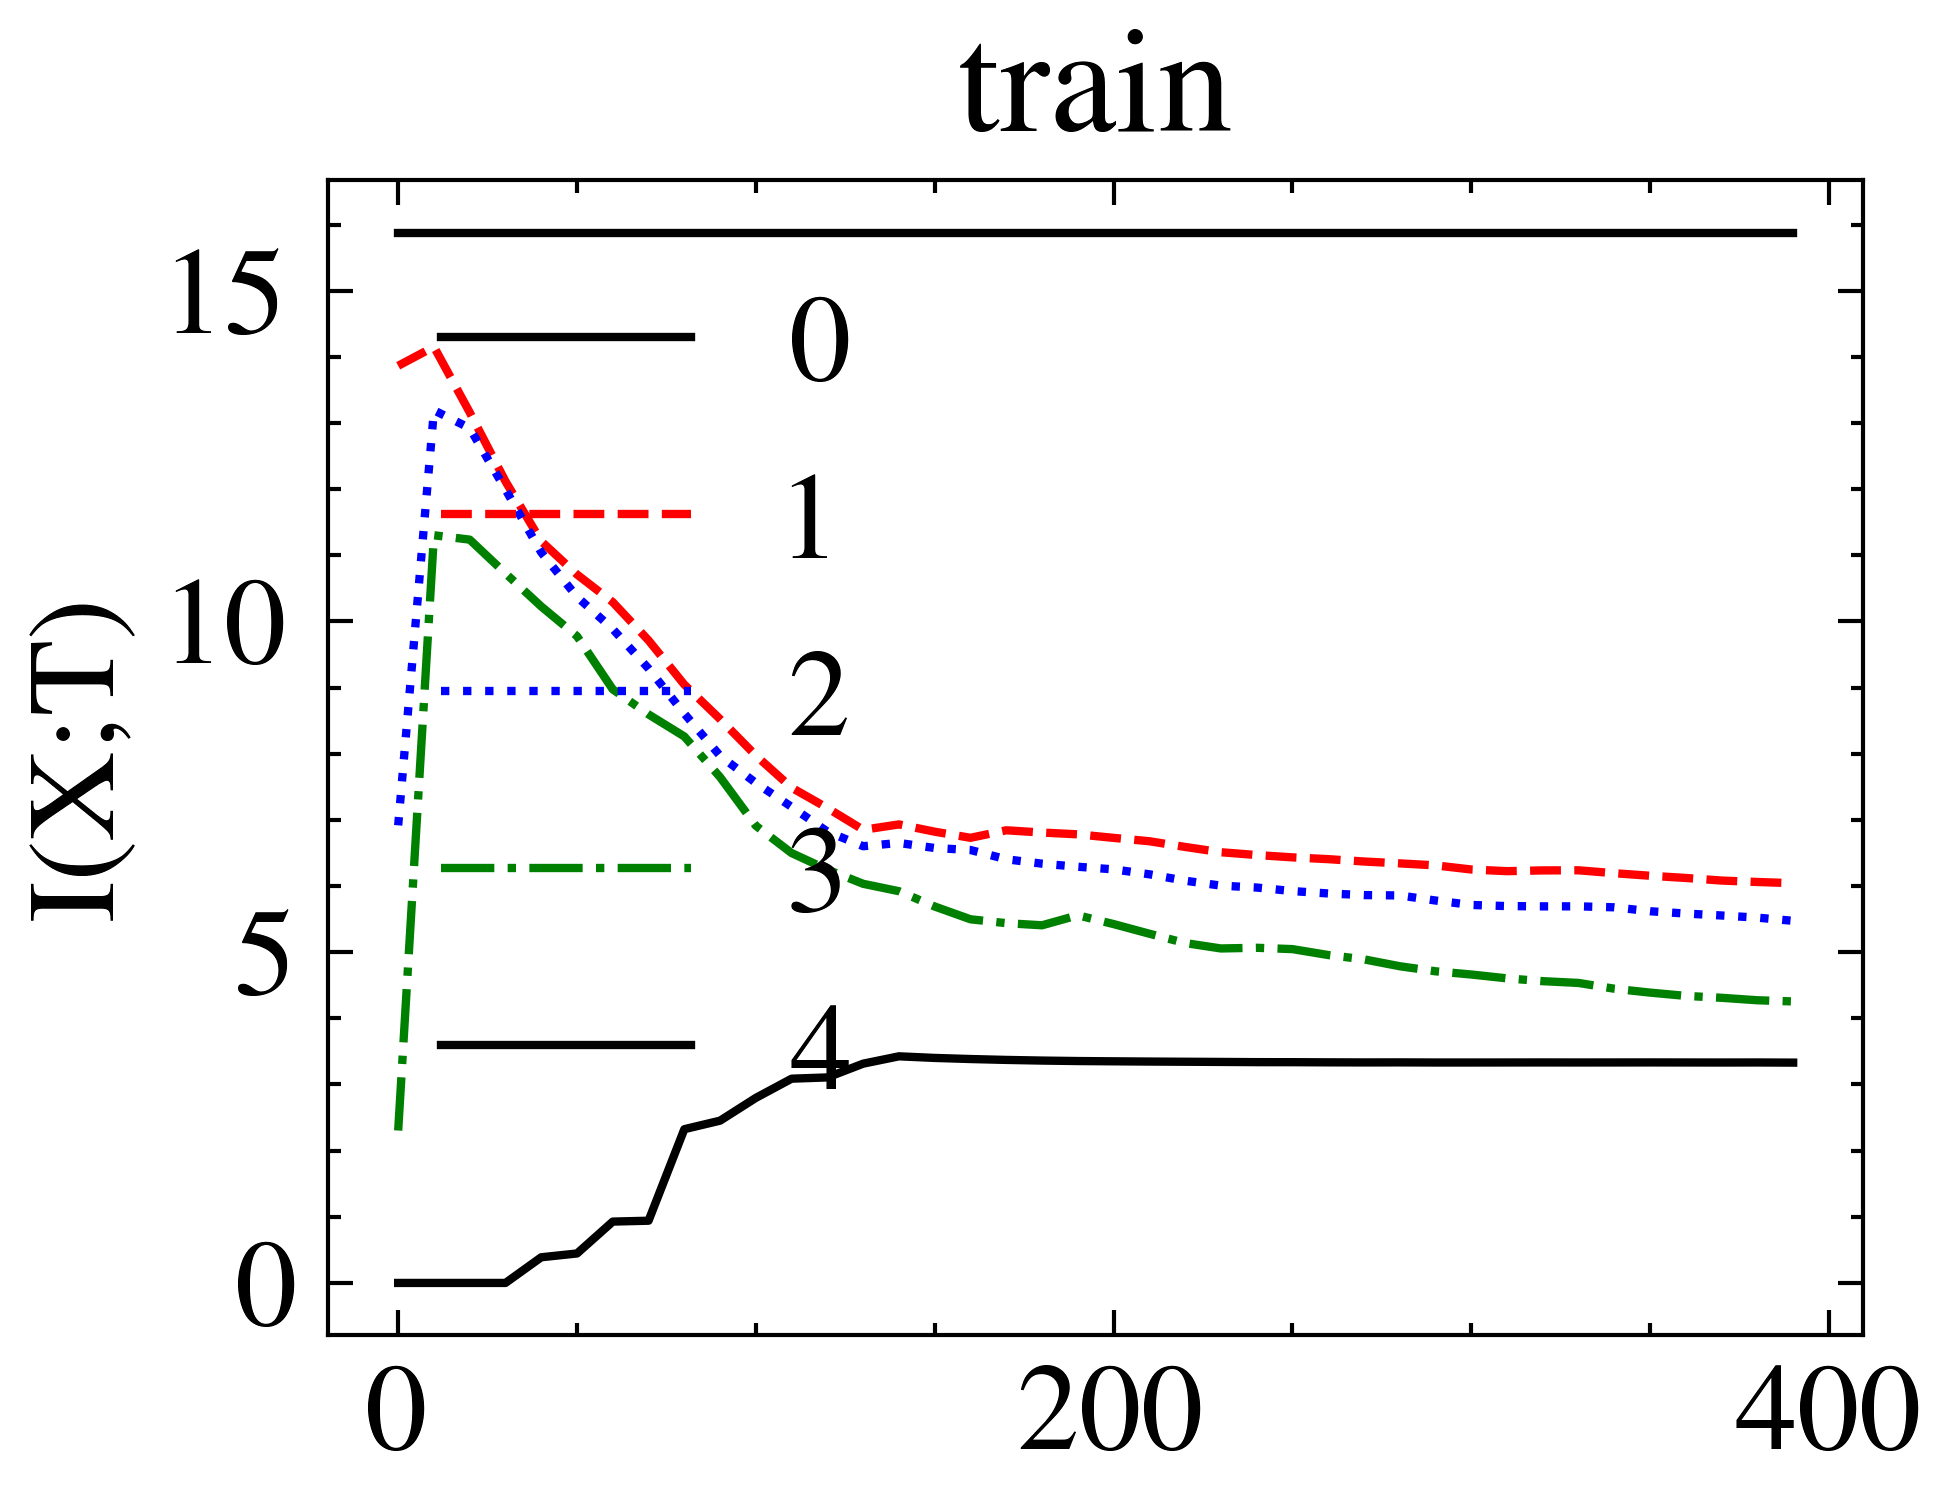

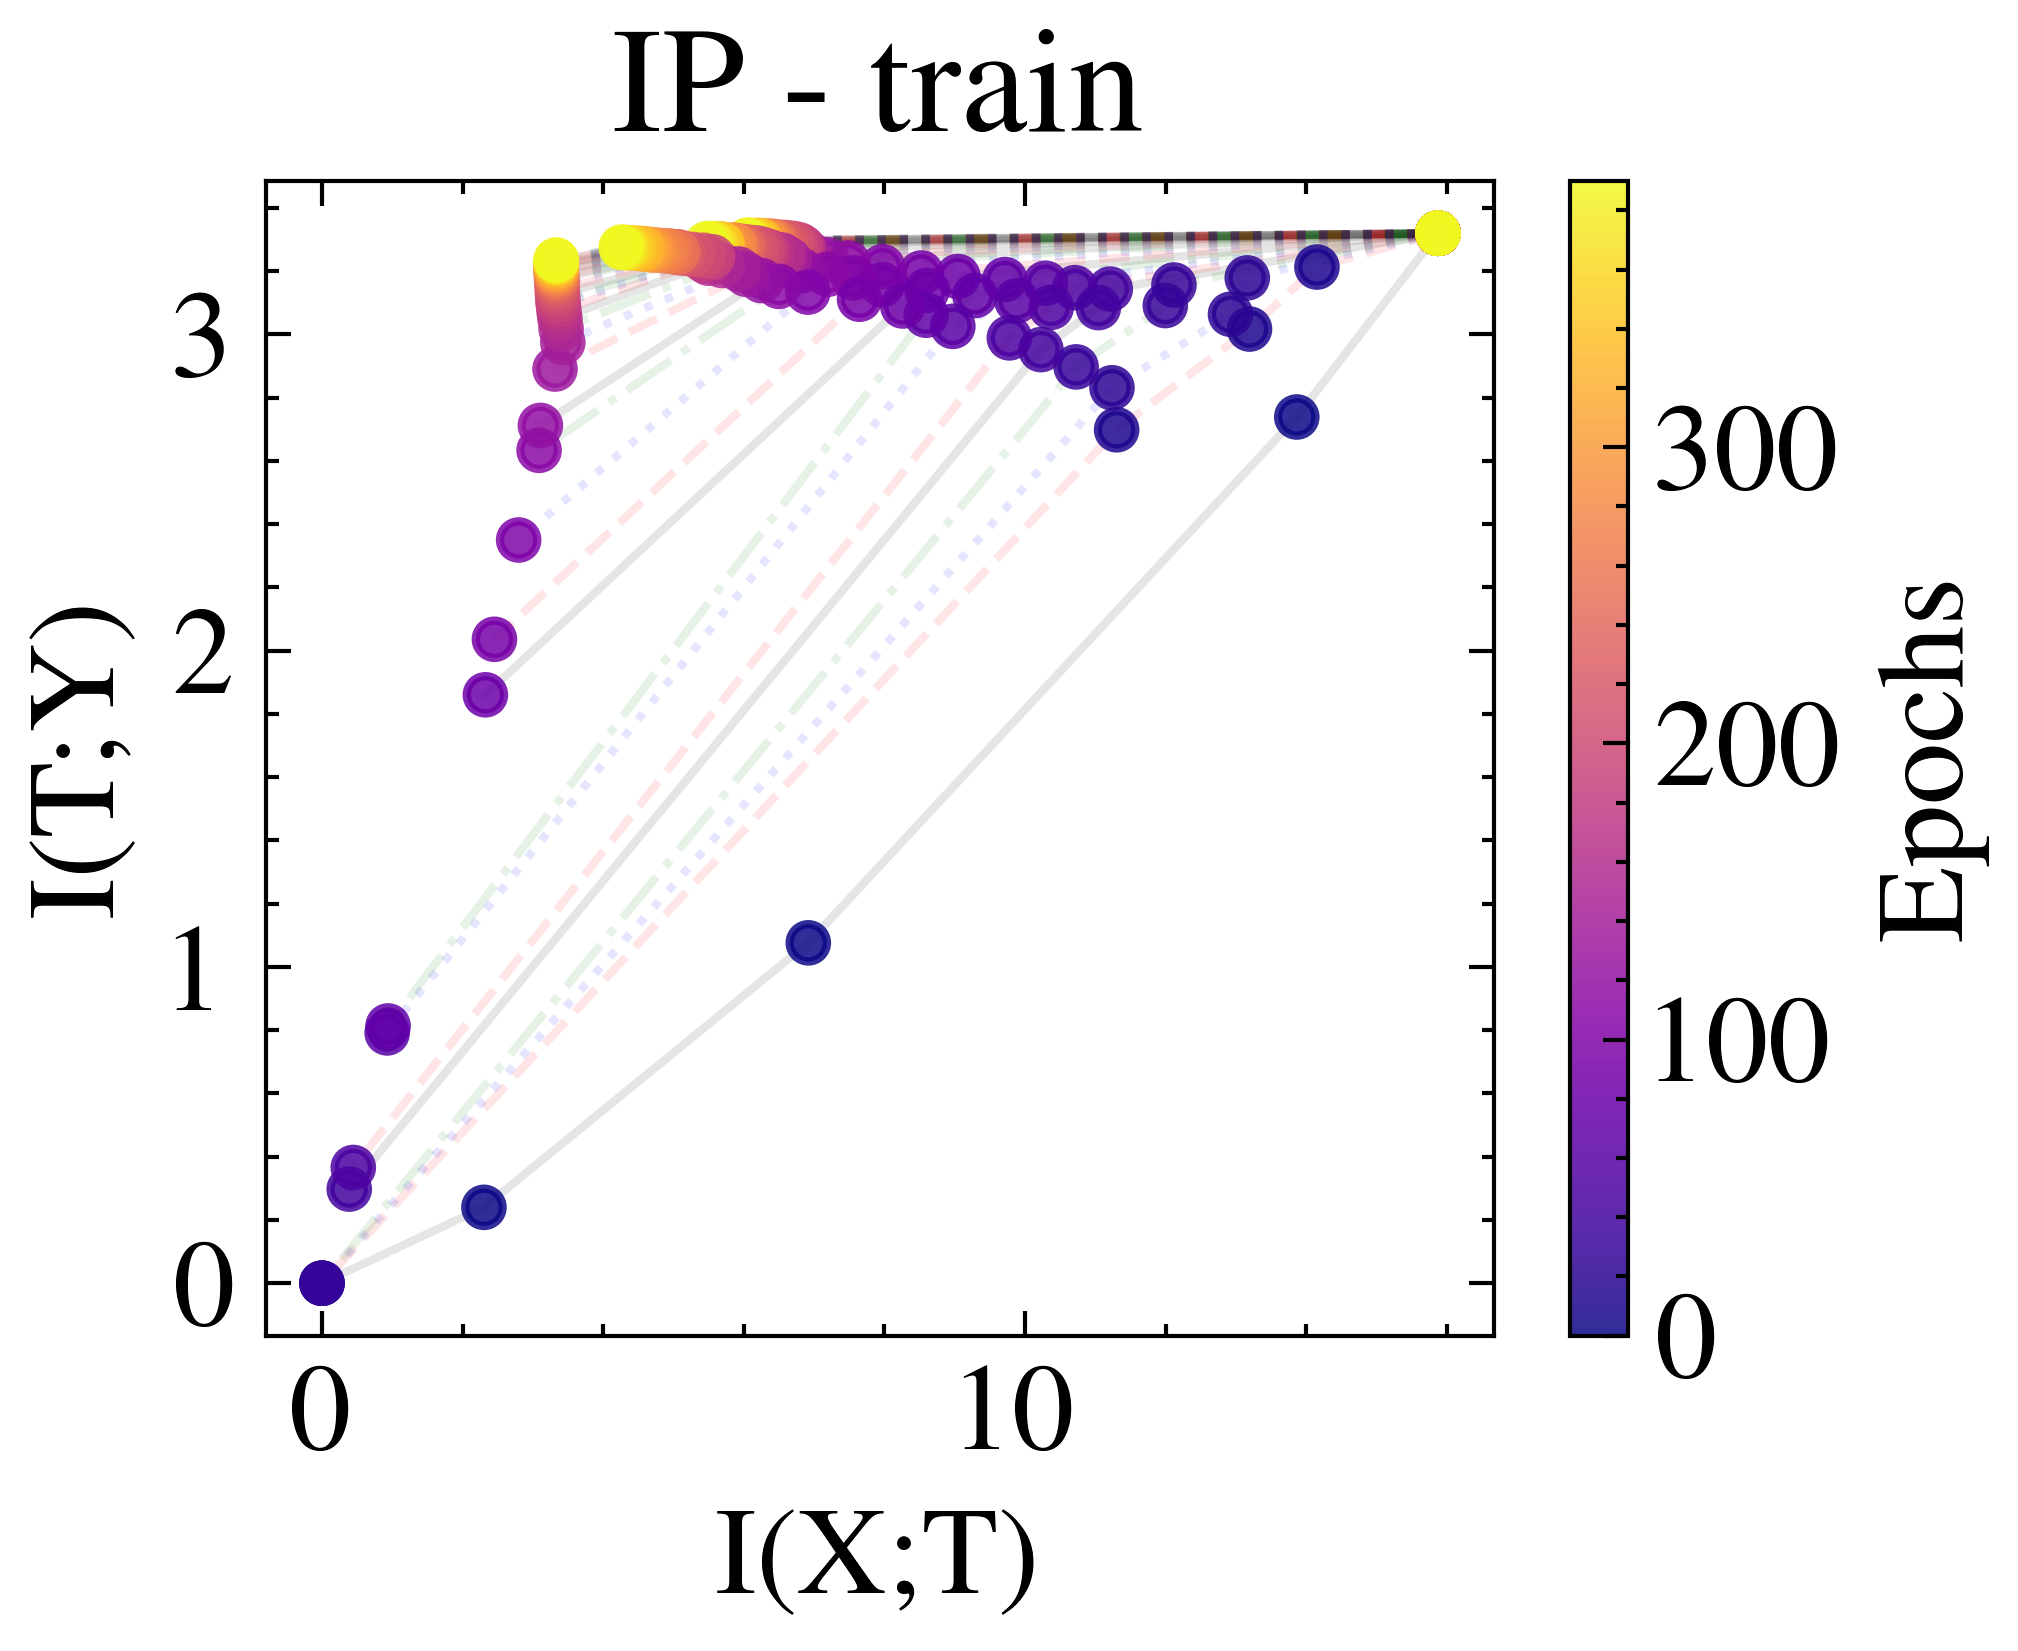

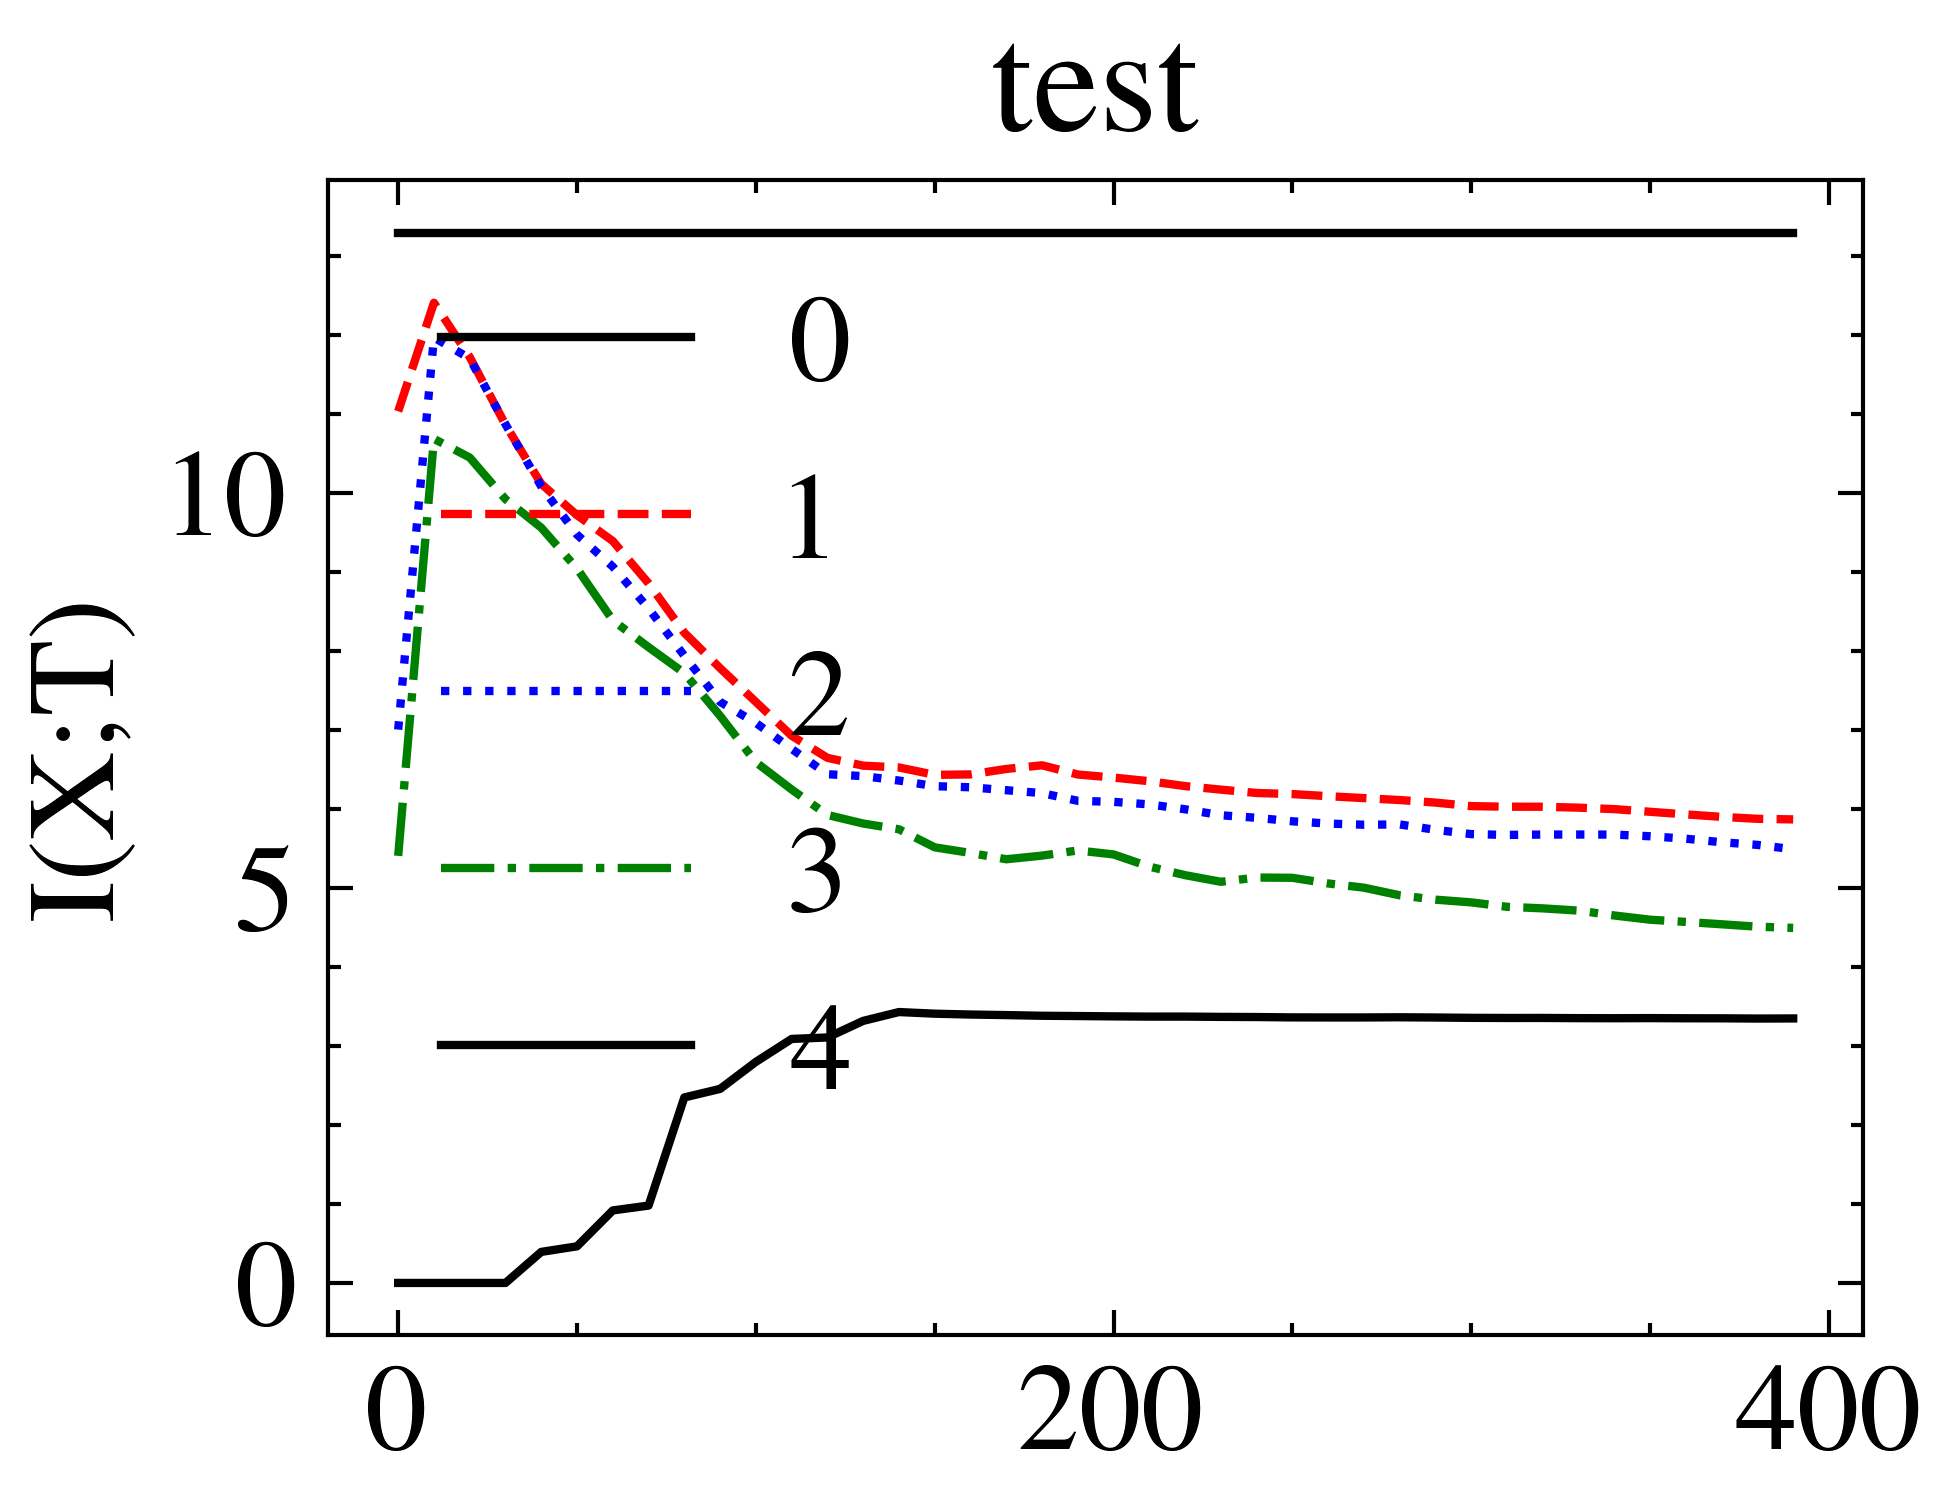

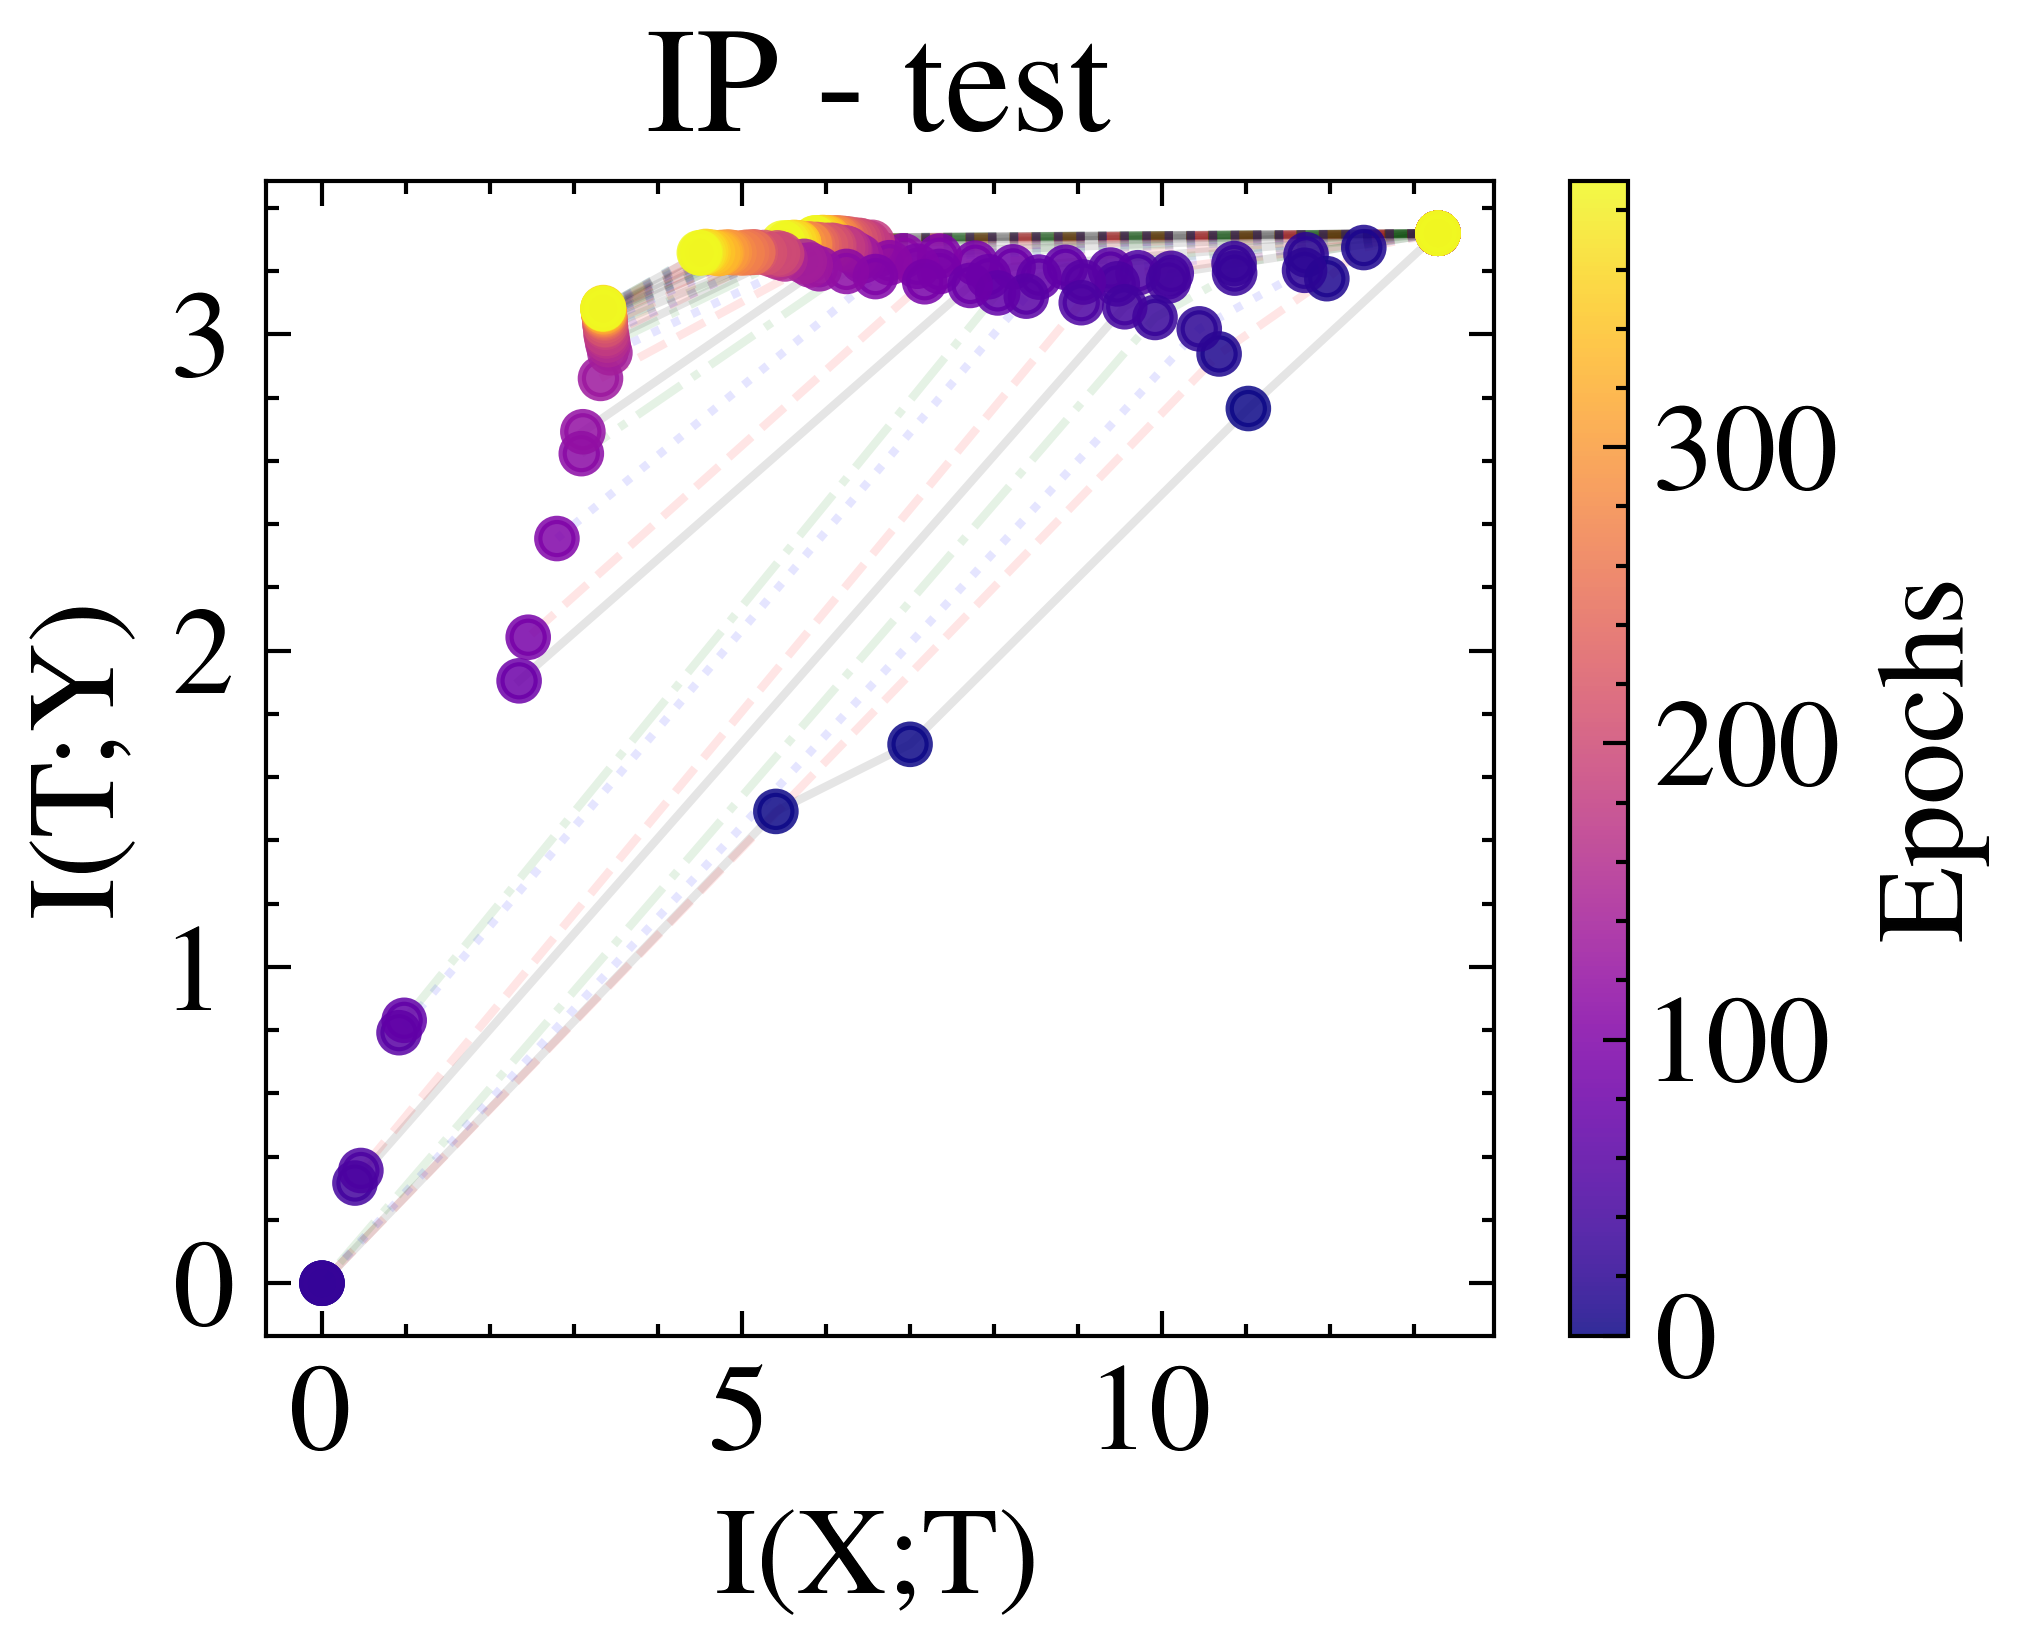

In [34]:
# 定义训练和测试函数
def run_training(model, criterion, optimizer, loader, epochs=5000, mi_cycle=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    losses = {'train': [], 'test': []}
    accuracy = {'train': [], 'test': []}
    running_mis_xt = {'train': [], 'test': []}
    running_mis_ty = {'train': [], 'test': []}

    def get_class_masks(loader):
        samples_split = dict()
        for phase in ['train', 'test']:
            samples_split[phase] = {}
            classes = loader[phase].dataset.targets.cpu().detach().numpy()
            for i in range(10):
                samples_split[phase][i] = classes == i
        return samples_split

    class_masks = get_class_masks(loader)

    for i in range(epochs):
        for phase in ['train', 'test']:
            phase_loss = 0.0
            phase_labels = torch.tensor([], dtype=torch.long).to(device)
            phase_outputs = torch.tensor([]).to(device)

            for inputs, labels in loader[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs, activations = model(inputs)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                phase_loss += loss.item()
                phase_labels = torch.cat((phase_labels, labels))
                phase_outputs = torch.cat((phase_outputs, outputs))

            if i % mi_cycle == 0:
                running_mis_xt[phase].append([])
                running_mis_ty[phase].append([])
                # Get activations from the model
                activations = [torch.tensor(act) for act in activations]
                for j in range(len(activations)):
                    activity = activations[j].cpu().detach().numpy()
                    binxm, binym = bin_calc_information(class_masks[phase], activity, binsize=0.5)
                    running_mis_xt[phase][-1].append(binxm)
                    running_mis_ty[phase][-1].append(binym)

            n = float(len(loader[phase].dataset))
            loss = phase_loss / n
            acc = (phase_labels == phase_outputs.argmax(dim=1)).sum() / n
            accuracy[phase].append(float(acc))

            losses[phase].append(loss)
            print(f'Epoch {i:>4} {phase}: loss {loss:>.4f} - acc {acc:>.4f}')

    # 保存训练结果
    tracking = {
        'n_layers': len(activations),
        'mi_cycle': mi_cycle,
        'losses': losses,
        'accuracy': accuracy,
        'running_mis_xt': running_mis_xt,
        'running_mis_ty': running_mis_ty,
    }
    with open('train.pkl', 'wb') as f:
        pickle.dump(tracking, f)

    return tracking

# 绘图函数
def plot_results(tracking):
    def format_epochs(x, pos):
        return int(x * tracking['mi_cycle'])

    # 绘制损失
    plt.figure()
    for phase in ['train', 'test']:
        plt.plot(tracking['losses'][phase], label=phase)
    plt.legend()
    plt.savefig('losses.png')
    plt.show()

    # 绘制准确率
    plt.figure()
    for phase in ['train', 'test']:
        plt.plot(tracking['accuracy'][phase], label=phase)
    plt.legend()
    plt.savefig('acc.png')
    plt.show()

    # 绘制信息平面
    for phase in ['train', 'test']:
        running_mis_xt = np.array(tracking['running_mis_xt'][phase])
        running_mis_ty = np.array(tracking['running_mis_ty'][phase])

        fig, ax = plt.subplots()
        plt.title(phase)
        for i in range(tracking['n_layers']):
            plt.plot(running_mis_xt[:, i], label=f'{i}')
        plt.legend()
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_epochs))
        plt.ylabel('I(X;T)')
        plt.savefig(f'plot_{phase}.png')
        plt.show()

        plt.figure()
        plt.title(f'IP - {phase}')
        c = list(range(len(running_mis_xt[:, 0])))
        for j in range(tracking['n_layers']):
            plt.scatter(running_mis_xt[:, j], running_mis_ty[:, j], c=c, cmap='plasma', s=20, alpha=0.85, zorder=1)
        for j in range(len(running_mis_xt[:, 0])):
            plt.plot(running_mis_xt[j, :], running_mis_ty[j, :], alpha=0.1, zorder=0)

        cbar = plt.colorbar(format=ticker.FuncFormatter(format_epochs))
        cbar.set_label('Epochs')

        plt.xlabel('I(X;T)')
        plt.ylabel('I(T;Y)')
        plt.savefig(f'IP_{phase}.png')
        plt.show()

# 数据准备
data = dict()
data['train'] = MNIST('./dataset', train=True, download=True, randomize=False)
data['test'] = MNIST('./dataset', train=False, download=True)

loader = dict()
loader['train'] = DataLoader(data['train'], batch_size=60000, shuffle=False)
loader['test'] = DataLoader(data['test'], batch_size=10000, shuffle=False)

# 配置和训练
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'to device: {device}')
net = Net().to(device)

criterion = torch.nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# 运行训练和测试
tracking = run_training(net, criterion, optimizer, loader, epochs=400, mi_cycle=10)

# 绘图
plot_results(tracking)

In [35]:
tracking

{'n_layers': 5,
 'mi_cycle': 10,
 'losses': {'train': [2.30299375,
   2.2961104166666666,
   2.289843229166667,
   2.2836791666666665,
   2.278121614583333,
   2.2733260416666665,
   2.2689807291666666,
   2.2649625,
   2.261238802083333,
   2.2577471354166665,
   2.25441875,
   2.2511984375,
   2.2480546875,
   2.2449768229166667,
   2.2419502604166666,
   2.2389497395833335,
   2.235951822916667,
   2.232950520833333,
   2.2299375,
   2.226895572916667,
   2.2238106770833332,
   2.2206770833333334,
   2.2174895833333332,
   2.21425078125,
   2.2109638020833335,
   2.2076348958333334,
   2.2042669270833333,
   2.2008645833333333,
   2.1974229166666666,
   2.193940625,
   2.190415625,
   2.186844010416667,
   2.183222265625,
   2.1795506510416667,
   2.1758298177083333,
   2.1720604166666666,
   2.1682434895833333,
   2.1643799479166668,
   2.160470703125,
   2.1565131510416666,
   2.1525063802083335,
   2.148451302083333,
   2.1443455729166665,
   2.140190494791667,
   2.1359877604166

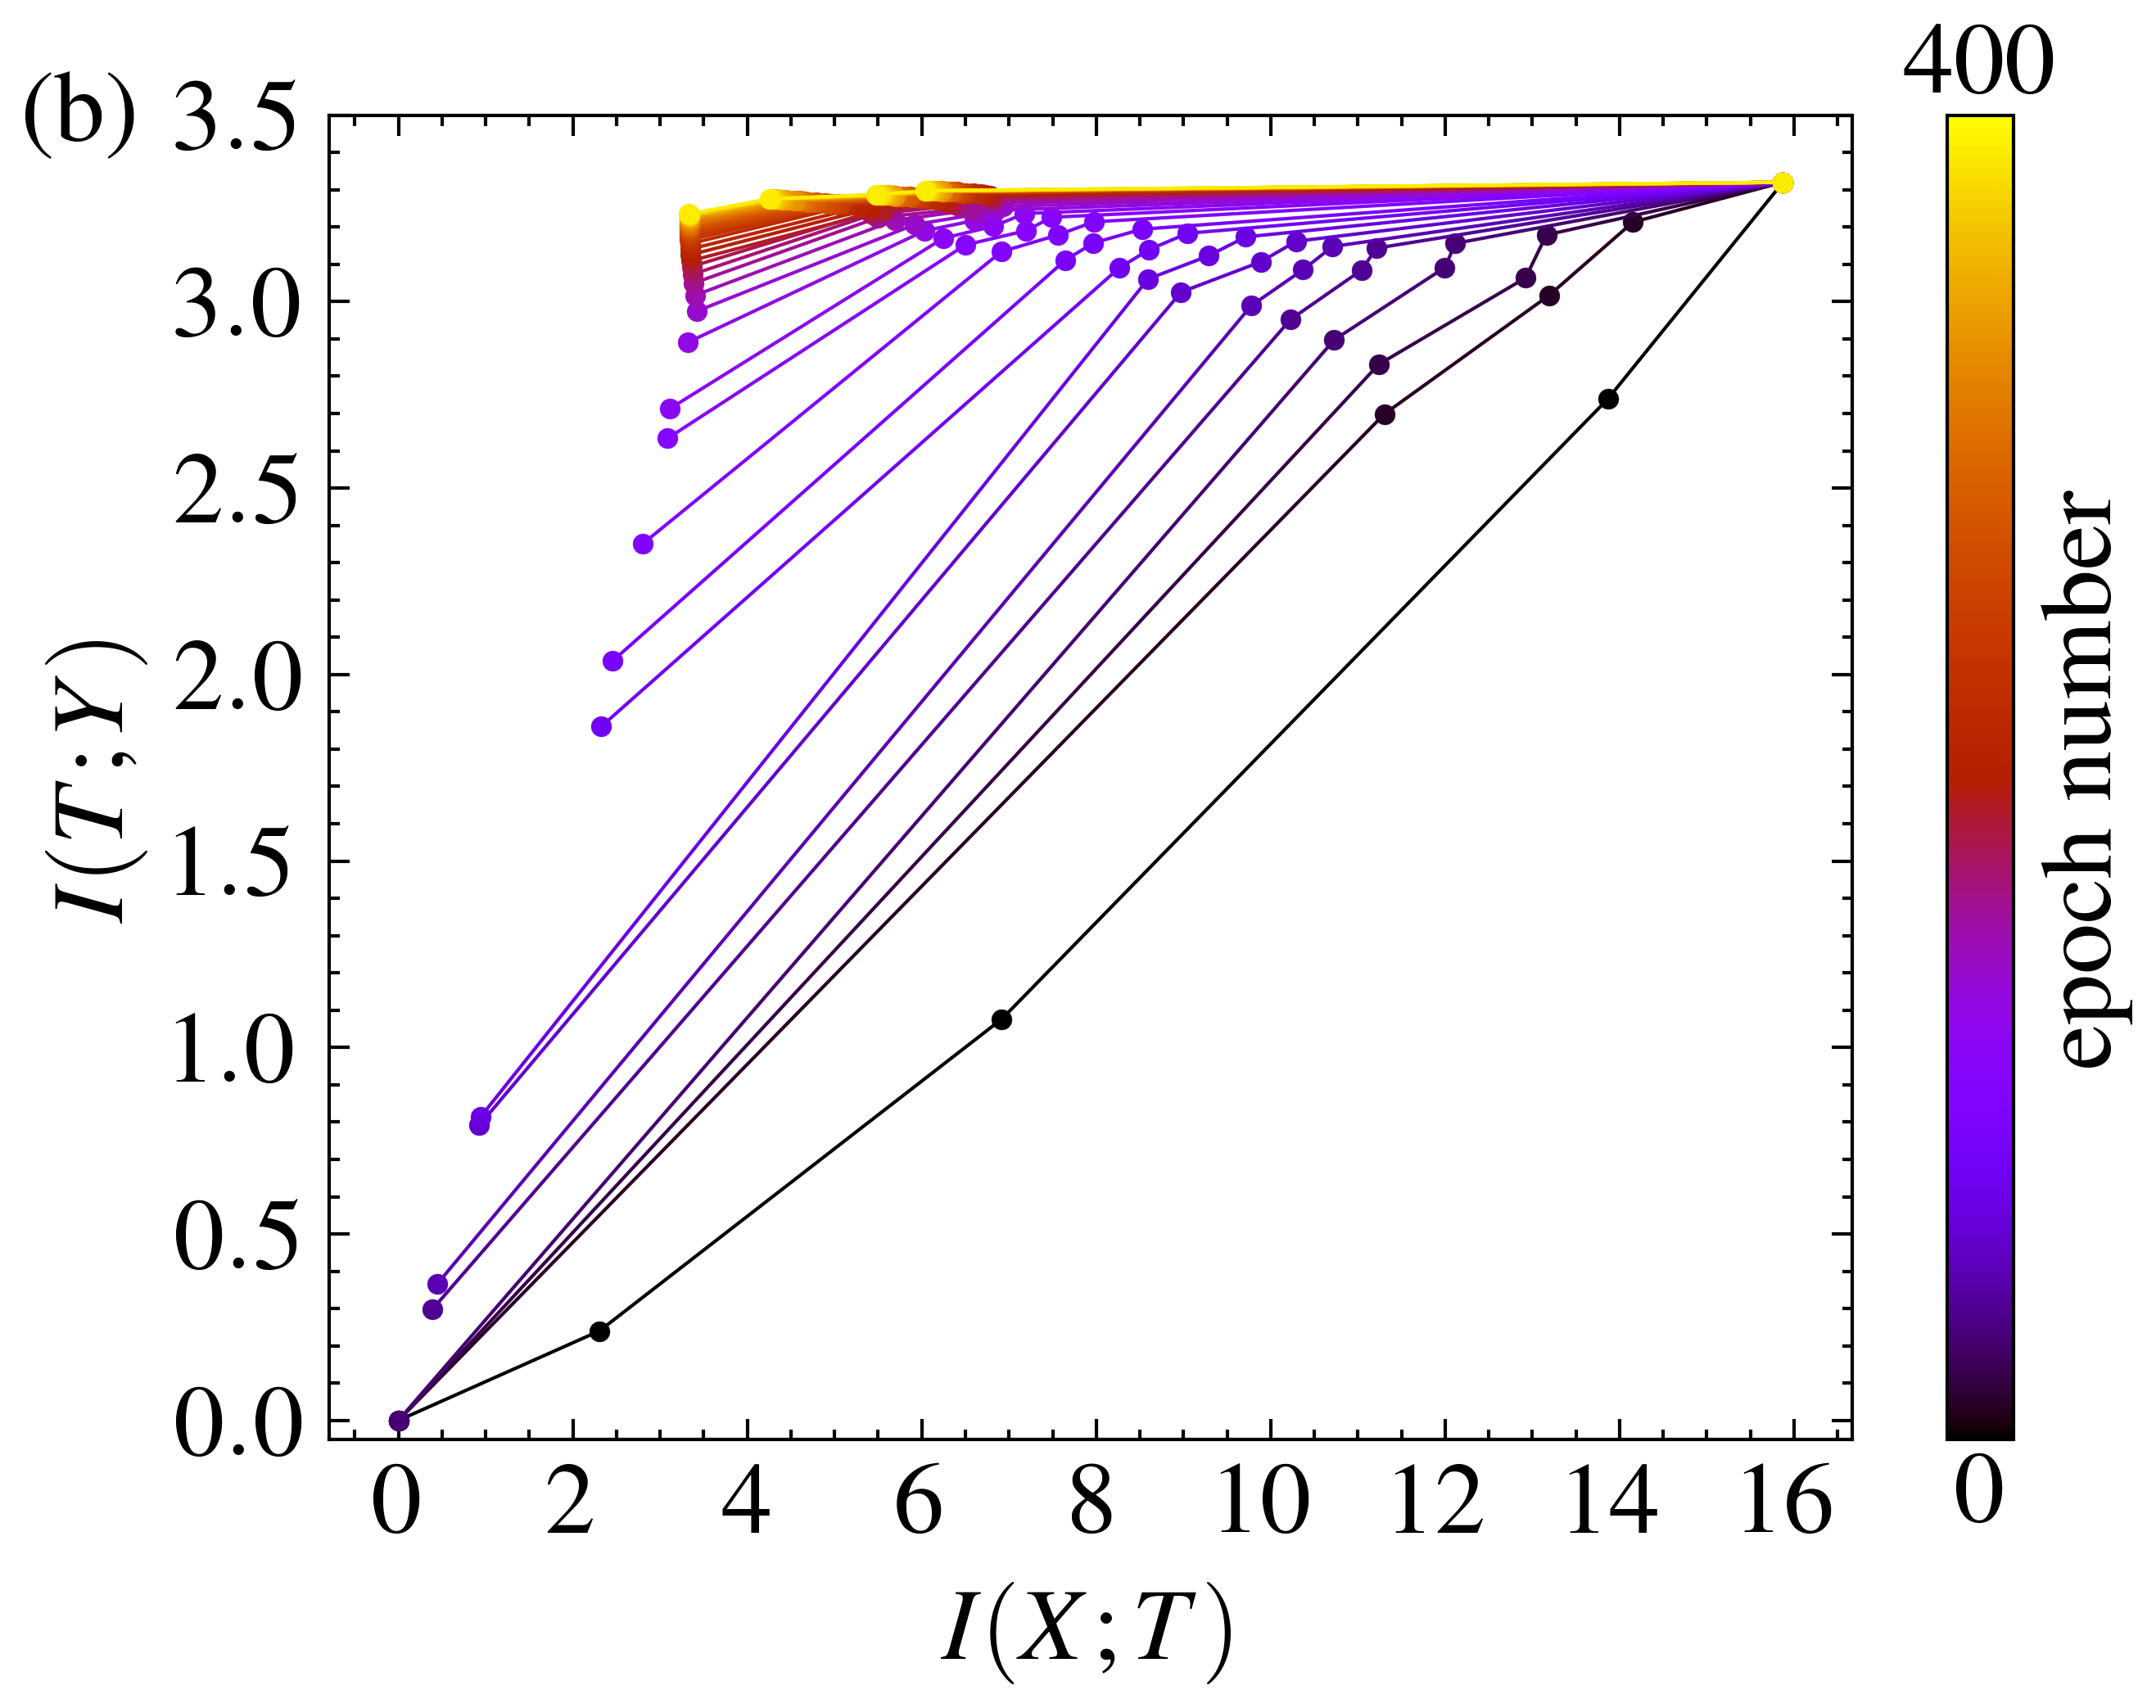

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import scienceplots
plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.style.use(['science', 'ieee'])
mpl.rcParams.update({'font.size': 15})

def plot_information_plane(IXT_array, ITY_array, num_epochs, every_n):
    assert len(IXT_array) == len(ITY_array)

    max_index = len(IXT_array)

    fig, ax = plt.subplots(figsize=(5, 3.5))
    ax.set_xlabel('$I(X;T)$', fontsize=15)
    ax.set_ylabel('$I(T;Y)$', fontsize=15)

    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, num_epochs + 1)]

    for i in range(0, max_index):
        IXT = IXT_array[i, :]
        ITY = ITY_array[i, :]
        ax.plot(IXT, ITY, marker='o', markersize=3, markeredgewidth=0.04,
                linestyle='-', linewidth=0.5, color=colors[i * every_n], zorder=10)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm._A = []

    # 使用ax参数指定颜色条位置
    cbar = plt.colorbar(sm, ax=ax, ticks=[])
    cbar.set_label('epoch number', fontsize=15)
    cbar.ax.tick_params(labelsize=15)
    cbar.ax.text(0.5, -0.01, 0, transform=cbar.ax.transAxes, va='top', ha='center')
    cbar.ax.text(0.5, 1.0, str(num_epochs), transform=cbar.ax.transAxes, va='bottom', ha='center')

    ax.set_xticks([0, 2, 4, 6, 8, 10, 12, 14, 16])
    ax.set_yticks([0, 0.5, 1, 1.5, 2, 2.5, 3.0, 3.5])
    ax.set_ylim(-0.05, 3.5)  # 修改y轴坐标范围
    # Adjust coordinates of text according to the plot area
    ax.text(-0.2, 0.98, '(b)', fontdict={'size': 15, 'color': 'black'}, transform=ax.transAxes)

    fig.savefig('D:/深度学习与信息论/Fig7b.eps', dpi=800)
    plt.show()

IXT_array = np.array(tracking['running_mis_xt']['train'])
ITY_array = np.array(tracking['running_mis_ty']['train'])

plot_information_plane(IXT_array, ITY_array, num_epochs=400, every_n=10)

to device: cuda
Epoch    0 train: loss 2.3029 - acc 0.1038
Epoch    0 test: loss 2.2679 - acc 0.3349
Epoch    1 train: loss 2.2687 - acc 0.3257
Epoch    1 test: loss 2.2500 - acc 0.5370
Epoch    2 train: loss 2.2509 - acc 0.5285
Epoch    2 test: loss 2.2429 - acc 0.5565
Epoch    3 train: loss 2.2441 - acc 0.5397
Epoch    3 test: loss 2.2323 - acc 0.5993
Epoch    4 train: loss 2.2332 - acc 0.5924
Epoch    4 test: loss 2.2258 - acc 0.6143
Epoch    5 train: loss 2.2264 - acc 0.6145
Epoch    5 test: loss 2.2182 - acc 0.6476
Epoch    6 train: loss 2.2187 - acc 0.6500
Epoch    6 test: loss 2.2128 - acc 0.6718
Epoch    7 train: loss 2.2133 - acc 0.6753
Epoch    7 test: loss 2.2079 - acc 0.6900
Epoch    8 train: loss 2.2085 - acc 0.6913
Epoch    8 test: loss 2.2025 - acc 0.7007
Epoch    9 train: loss 2.2031 - acc 0.7019
Epoch    9 test: loss 2.1973 - acc 0.7066
Epoch   10 train: loss 2.1978 - acc 0.7093
Epoch   10 test: loss 2.1921 - acc 0.7131
Epoch   11 train: loss 2.1925 - acc 0.7160
Epoch 

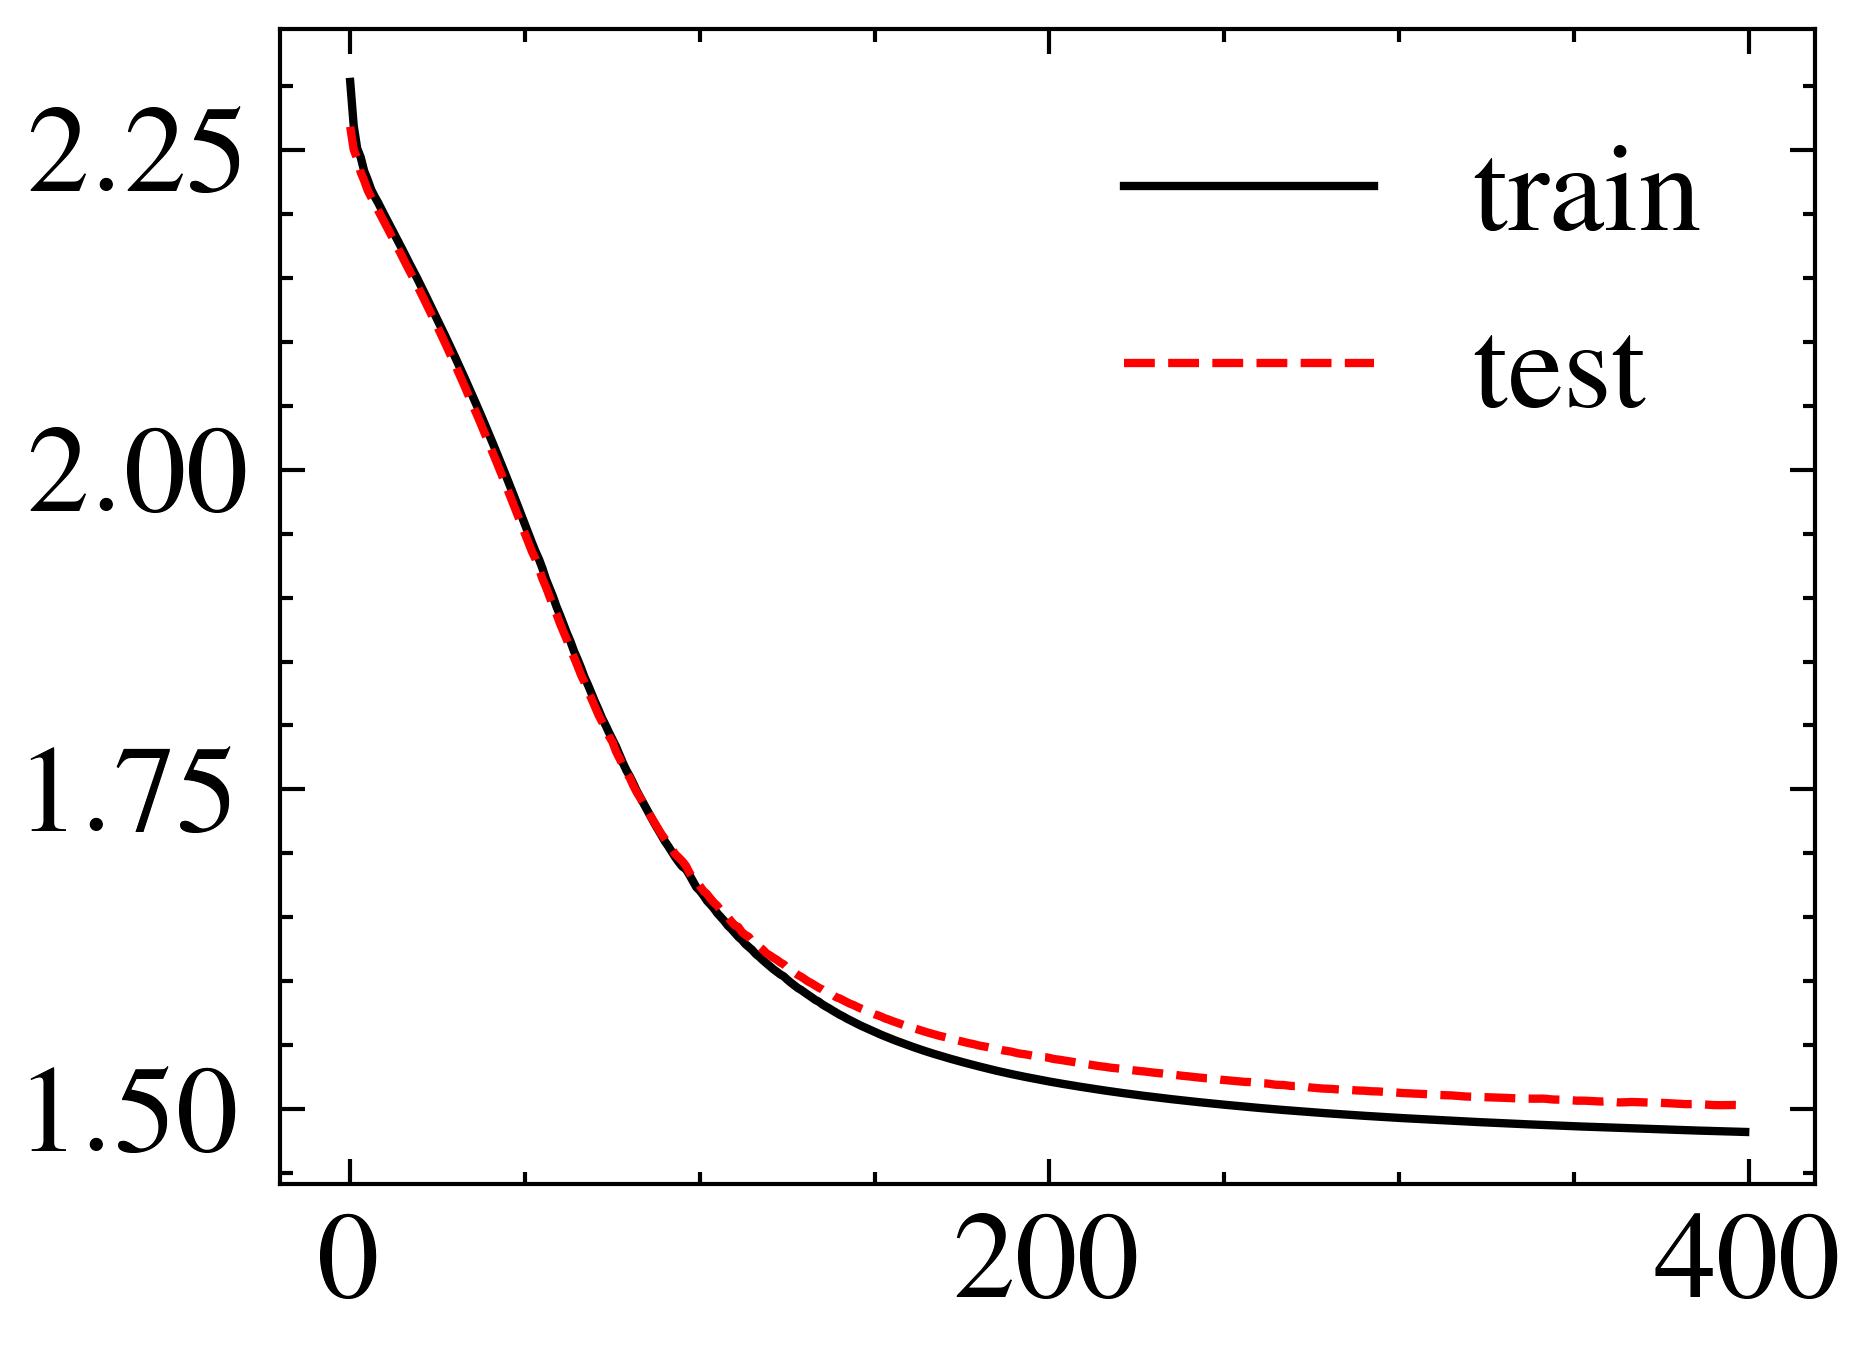

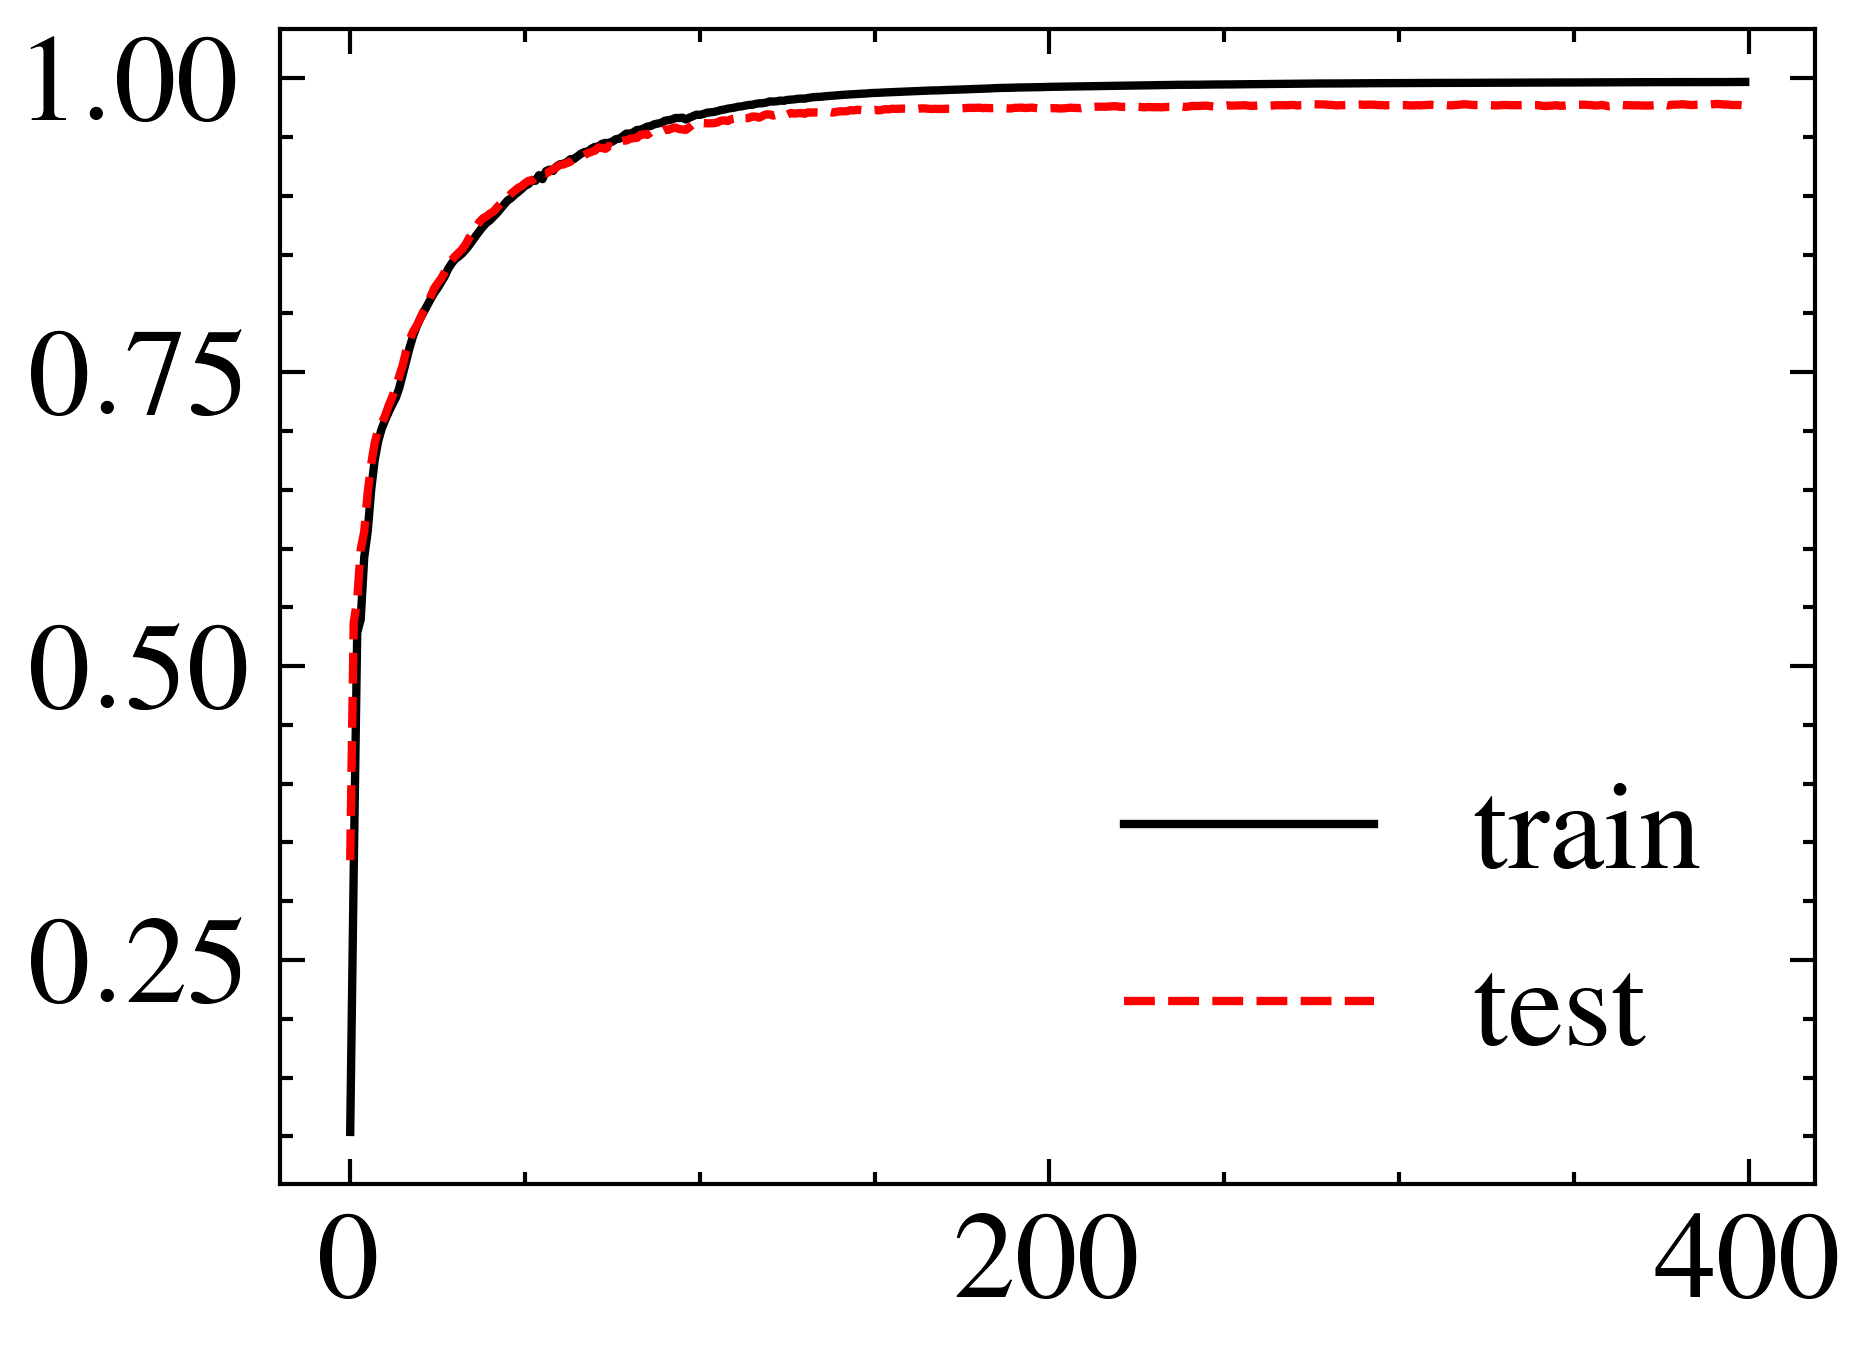

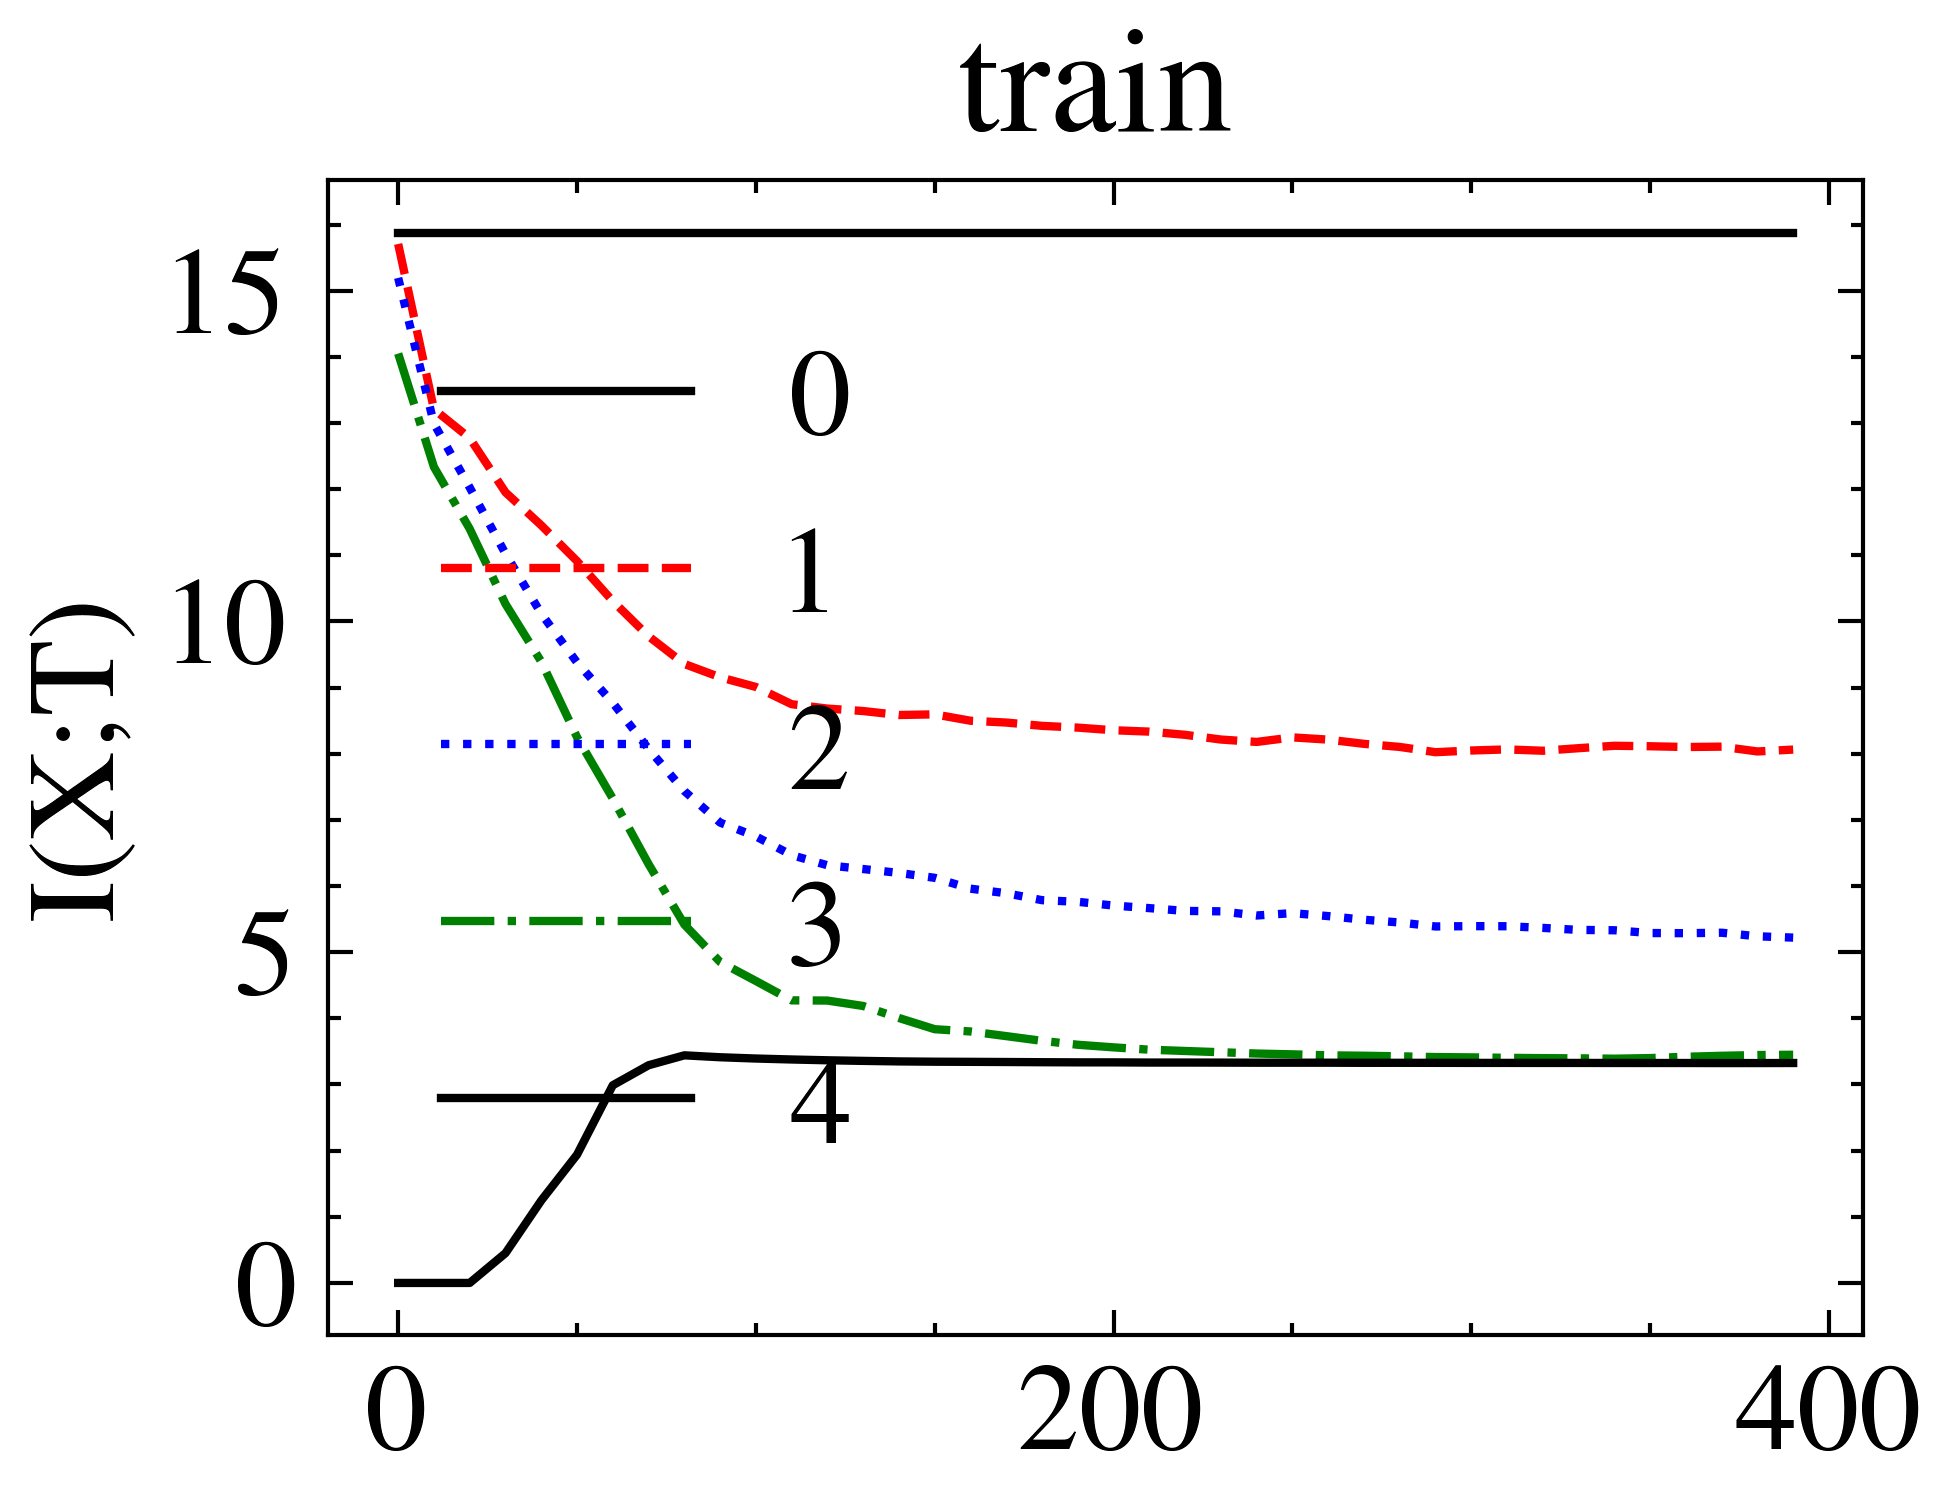

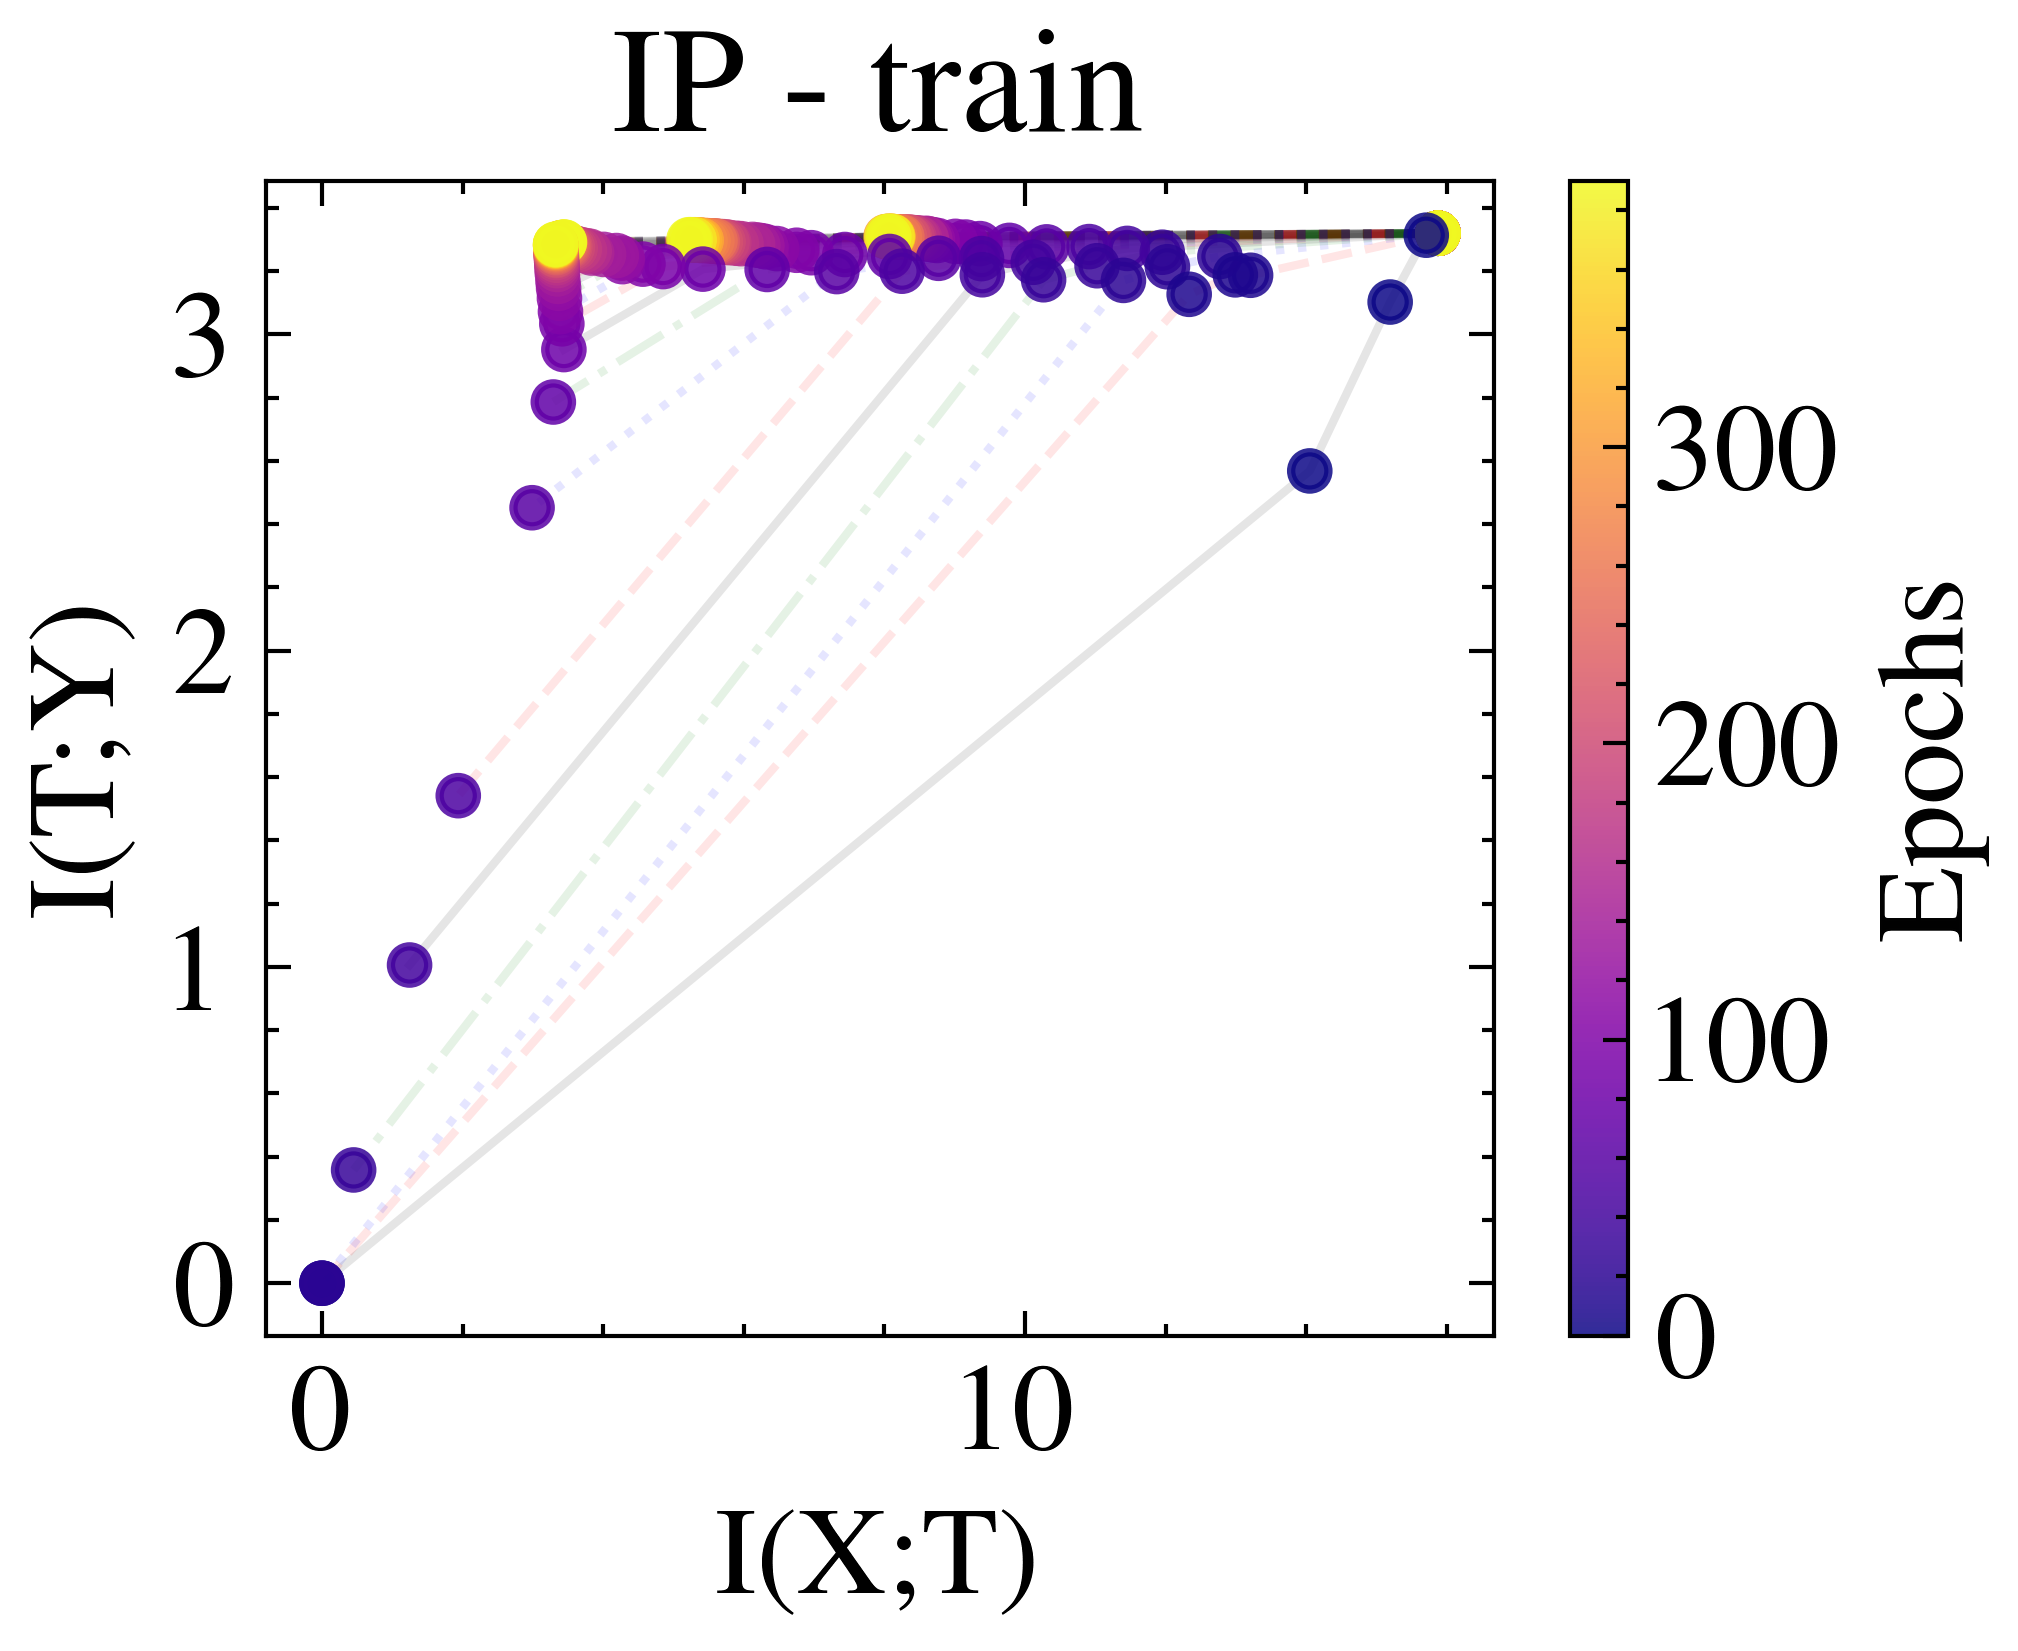

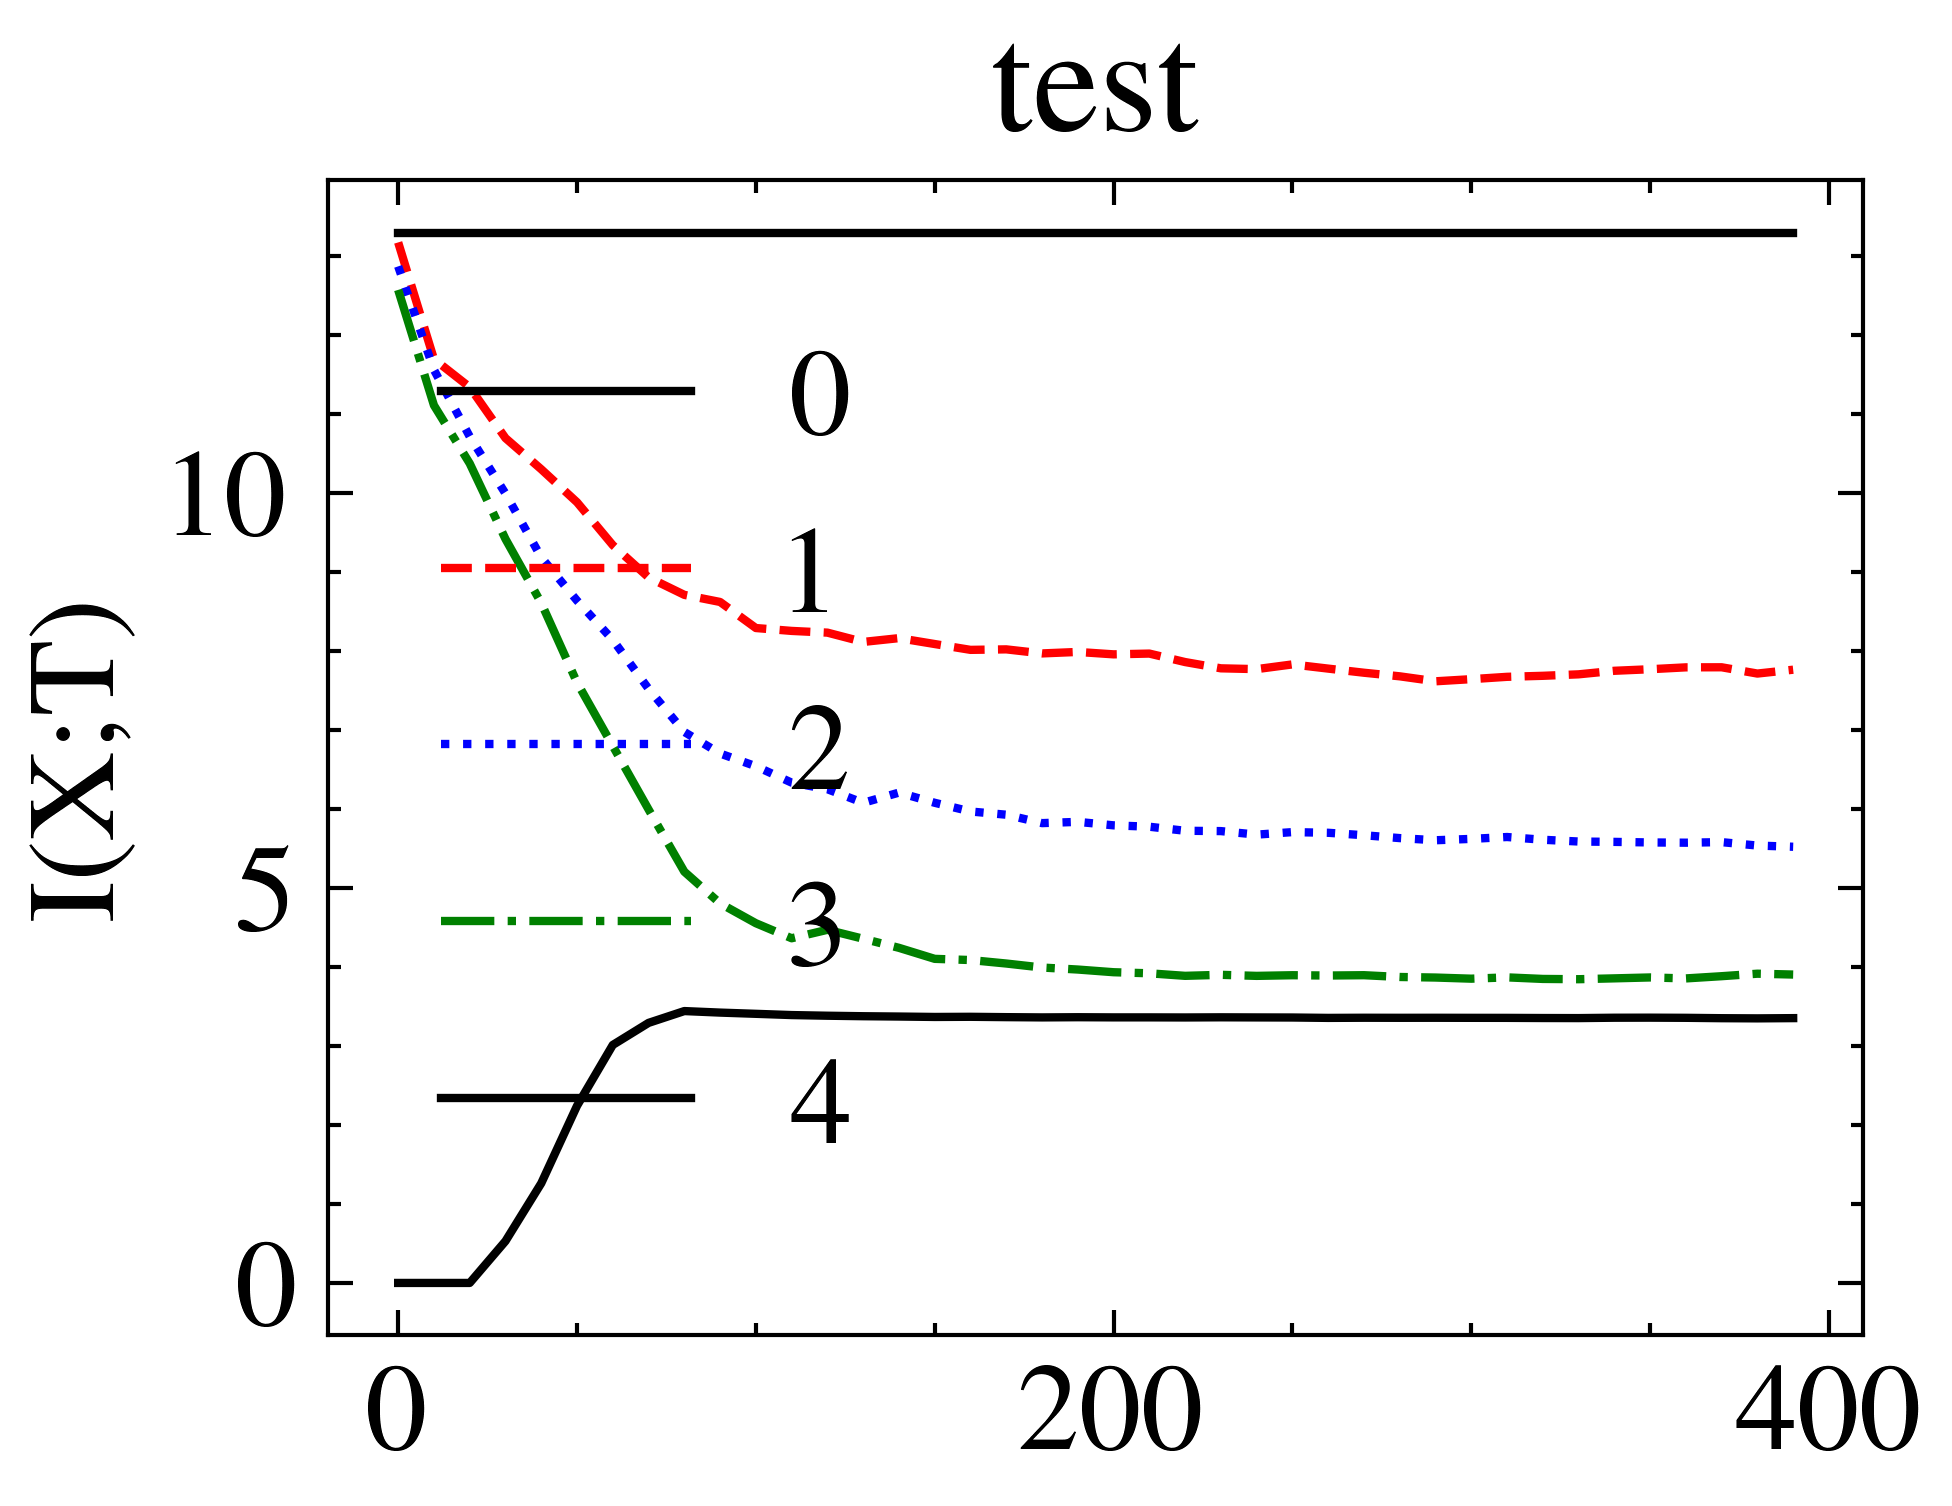

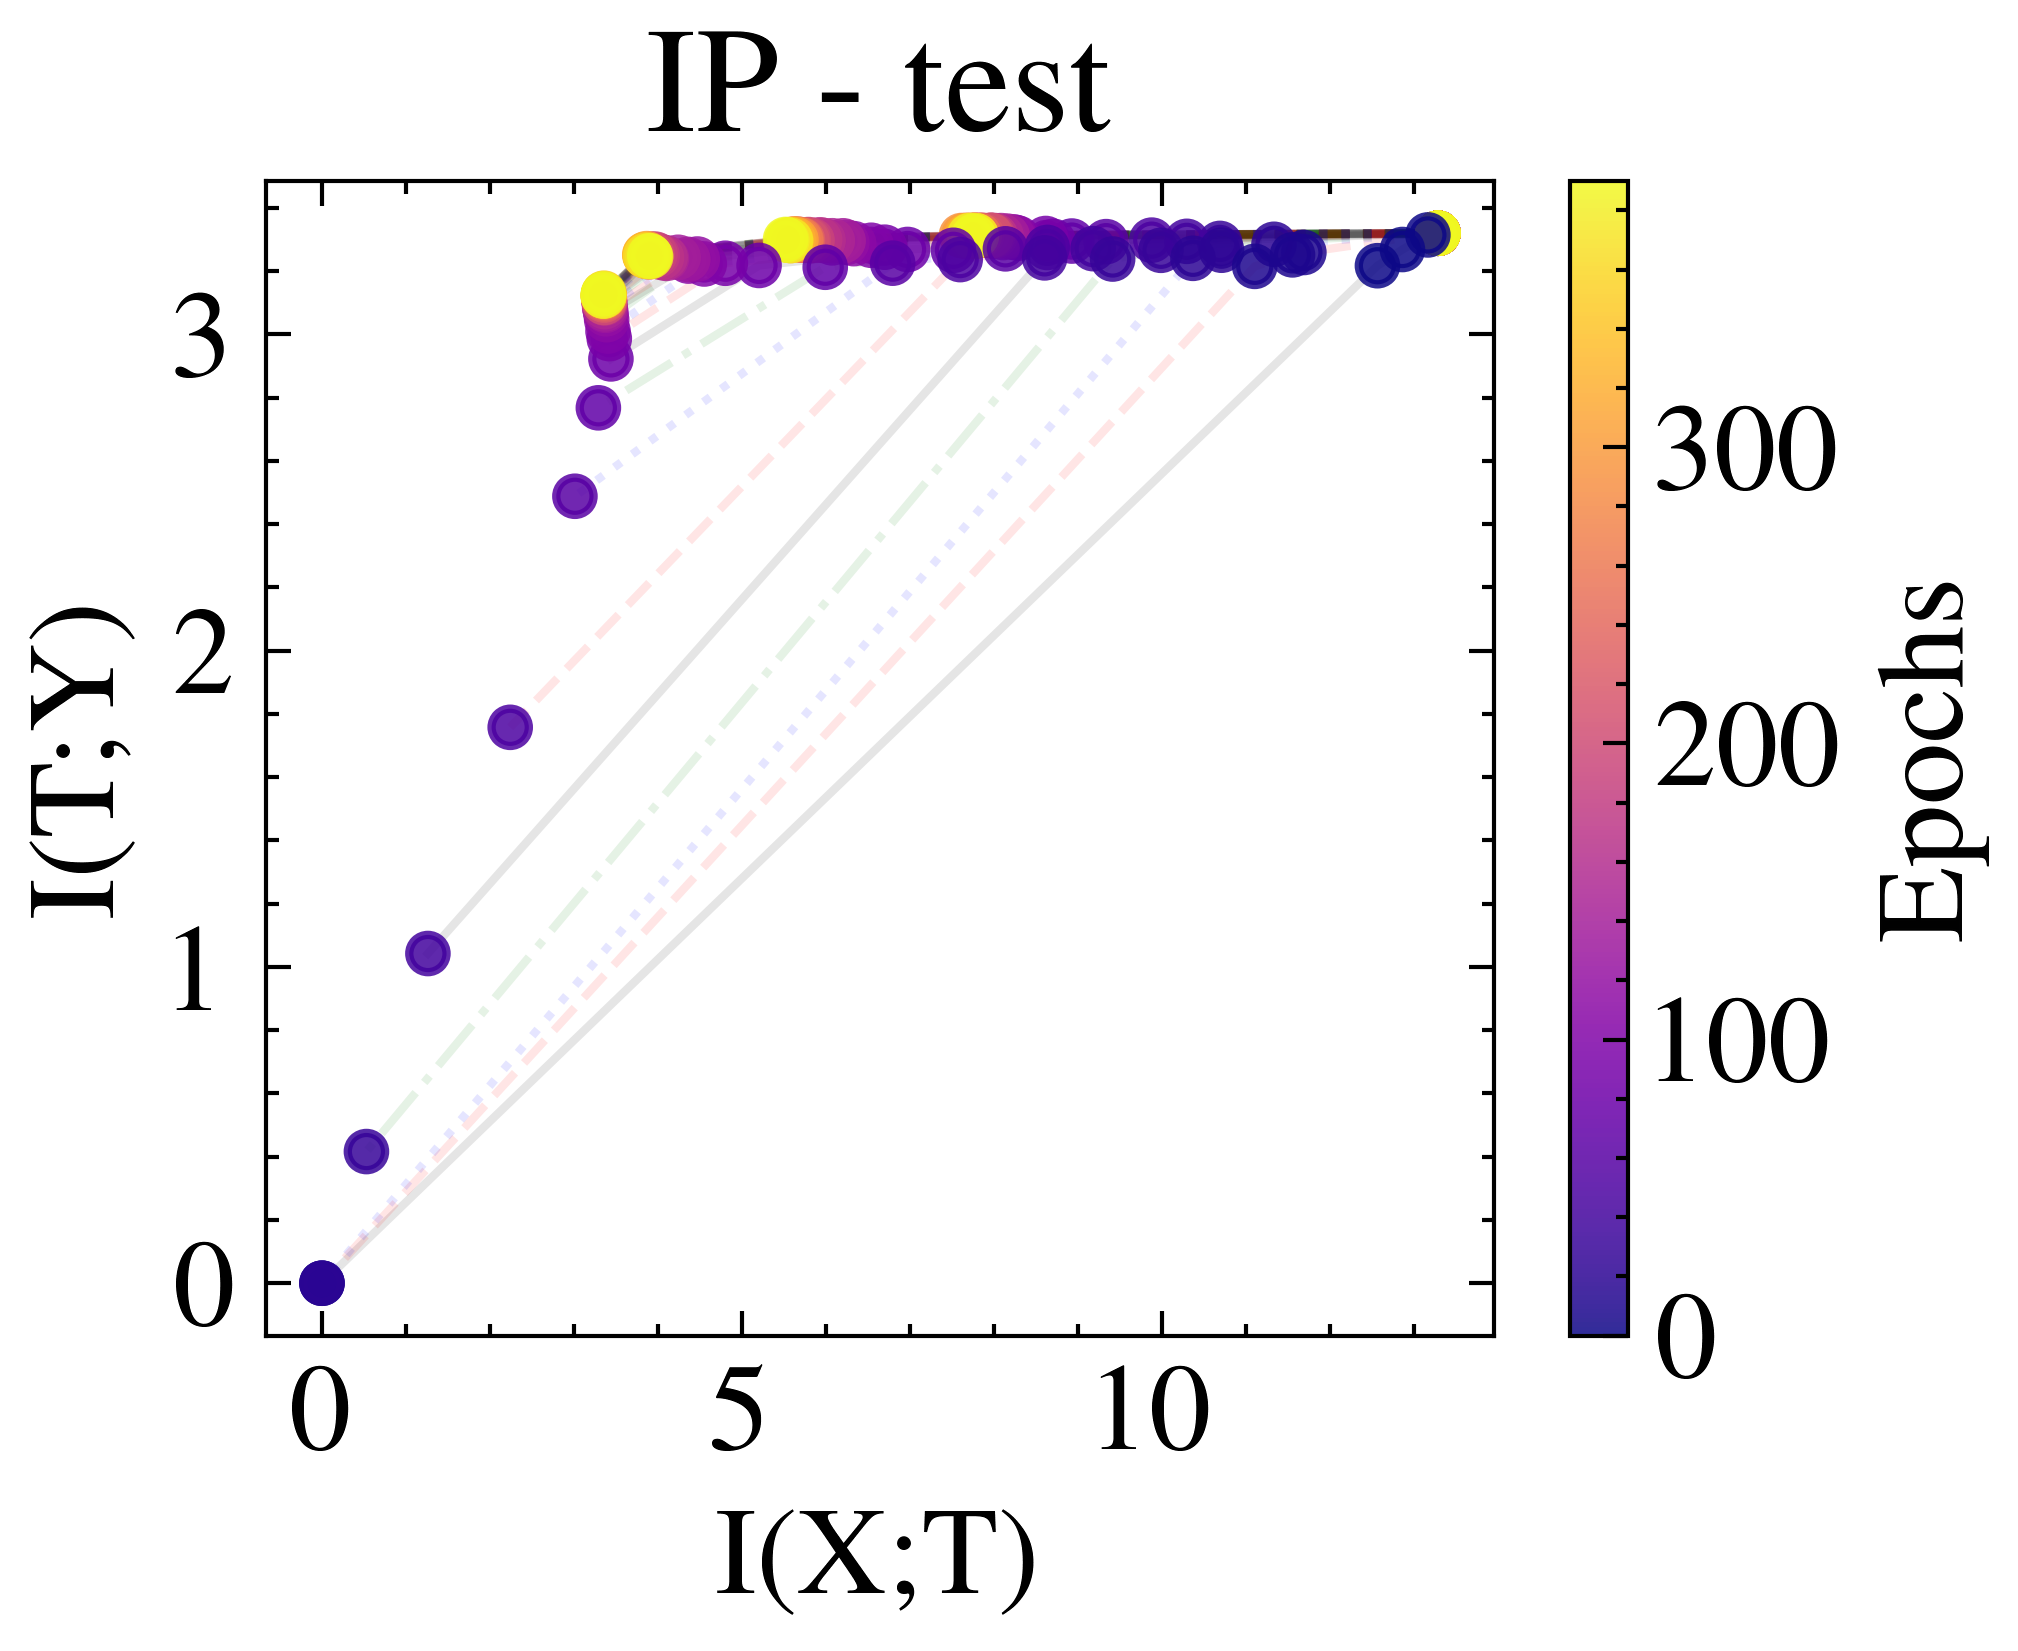

In [57]:
### erf(x/sigma)
####################################################
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
from random import seed
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pickle
import torch.nn as nn
import math
np.random.seed(1234)
seed(1234)
torch.manual_seed(1234)

def get_unique_probs(x):
    uniqueids = np.ascontiguousarray(x).view(np.dtype((np.void, x.dtype.itemsize * x.shape[1])))
    _, unique_inverse, unique_counts = np.unique(uniqueids, return_index=False, return_inverse=True, return_counts=True)
    return np.asarray(unique_counts / float(sum(unique_counts))), unique_inverse

def bin_calc_information(labelixs, layerdata, binsize):
    nats2bits = 1.0 / np.log(2)

    def get_h(d):
        digitized = np.floor(d / binsize).astype('int')
        p_ts, _ = get_unique_probs(digitized)
        return -np.sum(p_ts * np.log(p_ts))

    H_LAYER = get_h(layerdata)
    H_LAYER_GIVEN_OUTPUT = 0
    for label, ixs in labelixs.items():
        h = get_h(layerdata[ixs])
        H_LAYER_GIVEN_OUTPUT += ixs.mean() * h
    return nats2bits * H_LAYER, nats2bits * (H_LAYER - H_LAYER_GIVEN_OUTPUT)

# 定义 MNIST 数据集类
class MNIST(datasets.MNIST):
    def __init__(self, root, train=True, download=False, randomize=False):
        super(MNIST, self).__init__(root, train, download=True)  # Ensure download is True
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.targets = self.targets.to(device)
        self.data = self.data / 255.0
        self.data = self.data.view(-1, 28 * 28).to(device)

        if randomize:
            idx_rnd = torch.randperm(len(self.targets))
            self.targets = self.targets[idx_rnd]

    def __getitem__(self, index):
        img, targets = self.data[index], self.targets[index]
        return img, targets

class CustomActivation(nn.Module):
    def __init__(self):
        super(CustomActivation, self).__init__()
        self.sigma = nn.Parameter(torch.tensor([0.45]))  # Initialize sigma to 6.0

    def forward(self, input):
        #x = torch.erf(input / self.sigma)
        x = (torch.exp(2*input / self.sigma)-1) / (torch.exp(2*input / self.sigma)+1)
        return x

# 定义神经网络
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(784, 1024)
        self.fc2 = torch.nn.Linear(1024, 20)
        self.fc3 = torch.nn.Linear(20, 20)
        self.fc4 = torch.nn.Linear(20, 20)
        self.fc5 = torch.nn.Linear(20, 10)
        self.act1 = CustomActivation()
        self.act2 = CustomActivation()
        self.act3 = CustomActivation()
        self.act4 = CustomActivation()

    
    def forward(self, x):
        activations = []
        x = x.view(-1, 784)
        x = self.act1(self.fc1(x))
        activations.append(x.cpu().data.numpy())  # 将激活值移动到 CPU 上
        x = self.act2(self.fc2(x))
        activations.append(x.cpu().data.numpy())  # 将激活值移动到 CPU 上
        x = self.act3(self.fc3(x))
        activations.append(x.cpu().data.numpy())  # 将激活值移动到 CPU 上
        x = self.act4(self.fc4(x))
        activations.append(x.cpu().data.numpy())  # 将激活值移动到 CPU 上
        x = torch.softmax(self.fc5(x), dim=1)  # 添加dim参数以指定 softmax 在哪个维度上操作
        activations.append(x.cpu().data.numpy())  # 将激活值移动到 CPU 上
        return x, activations

# 定义训练和测试函数
def run_training(model, criterion, optimizer, loader, epochs=5000, mi_cycle=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    losses = {'train': [], 'test': []}
    accuracy = {'train': [], 'test': []}
    running_mis_xt = {'train': [], 'test': []}
    running_mis_ty = {'train': [], 'test': []}

    def get_class_masks(loader):
        samples_split = dict()
        for phase in ['train', 'test']:
            samples_split[phase] = {}
            classes = loader[phase].dataset.targets.cpu().detach().numpy()
            for i in range(10):
                samples_split[phase][i] = classes == i
        return samples_split

    class_masks = get_class_masks(loader)

    for i in range(epochs):
        for phase in ['train', 'test']:
            phase_loss = 0.0
            phase_labels = torch.tensor([], dtype=torch.long).to(device)
            phase_outputs = torch.tensor([]).to(device)

            for inputs, labels in loader[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs, activations = model(inputs)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                phase_loss += loss.item()
                phase_labels = torch.cat((phase_labels, labels))
                phase_outputs = torch.cat((phase_outputs, outputs))

            if i % mi_cycle == 0:
                running_mis_xt[phase].append([])
                running_mis_ty[phase].append([])
                # Get activations from the model
                activations = [torch.tensor(act) for act in activations]
                for j in range(len(activations)):
                    activity = activations[j].cpu().detach().numpy()
                    binxm, binym = bin_calc_information(class_masks[phase], activity, binsize=0.5)
                    running_mis_xt[phase][-1].append(binxm)
                    running_mis_ty[phase][-1].append(binym)

            n = float(len(loader[phase].dataset))
            loss = phase_loss / n
            acc = (phase_labels == phase_outputs.argmax(dim=1)).sum() / n
            accuracy[phase].append(float(acc))

            losses[phase].append(loss)
            print(f'Epoch {i:>4} {phase}: loss {loss:>.4f} - acc {acc:>.4f}')

    # 保存训练结果
    tracking = {
        'n_layers': len(activations),
        'mi_cycle': mi_cycle,
        'losses': losses,
        'accuracy': accuracy,
        'running_mis_xt': running_mis_xt,
        'running_mis_ty': running_mis_ty,
    }
    with open('train.pkl', 'wb') as f:
        pickle.dump(tracking, f)

    return tracking

# 绘图函数
def plot_results(tracking):
    def format_epochs(x, pos):
        return int(x * tracking['mi_cycle'])

    # 绘制损失
    plt.figure()
    for phase in ['train', 'test']:
        plt.plot(tracking['losses'][phase], label=phase)
    plt.legend()
    plt.savefig('losses.png')
    plt.show()

    # 绘制准确率
    plt.figure()
    for phase in ['train', 'test']:
        plt.plot(tracking['accuracy'][phase], label=phase)
    plt.legend()
    plt.savefig('acc.png')
    plt.show()

    # 绘制信息平面
    for phase in ['train', 'test']:
        running_mis_xt = np.array(tracking['running_mis_xt'][phase])
        running_mis_ty = np.array(tracking['running_mis_ty'][phase])

        fig, ax = plt.subplots()
        plt.title(phase)
        for i in range(tracking['n_layers']):
            plt.plot(running_mis_xt[:, i], label=f'{i}')
        plt.legend()
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_epochs))
        plt.ylabel('I(X;T)')
        plt.savefig(f'plot_{phase}.png')
        plt.show()

        plt.figure()
        plt.title(f'IP - {phase}')
        c = list(range(len(running_mis_xt[:, 0])))
        for j in range(tracking['n_layers']):
            plt.scatter(running_mis_xt[:, j], running_mis_ty[:, j], c=c, cmap='plasma', s=20, alpha=0.85, zorder=1)
        for j in range(len(running_mis_xt[:, 0])):
            plt.plot(running_mis_xt[j, :], running_mis_ty[j, :], alpha=0.1, zorder=0)

        cbar = plt.colorbar(format=ticker.FuncFormatter(format_epochs))
        cbar.set_label('Epochs')

        plt.xlabel('I(X;T)')
        plt.ylabel('I(T;Y)')
        plt.savefig(f'IP_{phase}.png')
        plt.show()

# 数据准备
data = dict()
data['train'] = MNIST('./dataset', train=True, download=True, randomize=False)
data['test'] = MNIST('./dataset', train=False, download=True)

loader = dict()
loader['train'] = DataLoader(data['train'], batch_size=60000, shuffle=False)
loader['test'] = DataLoader(data['test'], batch_size=10000, shuffle=False)

# 配置和训练
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'to device: {device}')
net = Net().to(device)

criterion = torch.nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# 运行训练和测试
trackingsigma = run_training(net, criterion, optimizer, loader, epochs=400, mi_cycle=10)

# 绘图
plot_results(trackingsigma)

In [58]:
trackingsigma

{'n_layers': 5,
 'mi_cycle': 10,
 'losses': {'train': [2.3029453125,
   2.268702864583333,
   2.2509197916666666,
   2.2440690104166667,
   2.2332497395833335,
   2.226396875,
   2.2187377604166665,
   2.213334114583333,
   2.2084979166666665,
   2.20307109375,
   2.19777890625,
   2.192497395833333,
   2.1872361979166666,
   2.1820854166666668,
   2.176898046875,
   2.1715981770833332,
   2.1661444010416666,
   2.1607143229166668,
   2.15550625,
   2.1503002604166666,
   2.1448317708333335,
   2.13925859375,
   2.1336477864583334,
   2.1280393229166665,
   2.1225001302083335,
   2.1168791666666666,
   2.111145703125,
   2.10540078125,
   2.099617578125,
   2.093798828125,
   2.0879268229166668,
   2.0819638020833335,
   2.0759755208333335,
   2.0699188802083333,
   2.06378671875,
   2.057605078125,
   2.051339583333333,
   2.0450611979166666,
   2.038676171875,
   2.0321908854166666,
   2.0256484375,
   2.019066015625,
   2.012412890625,
   2.005699088541667,
   1.998949609375,
   1.9

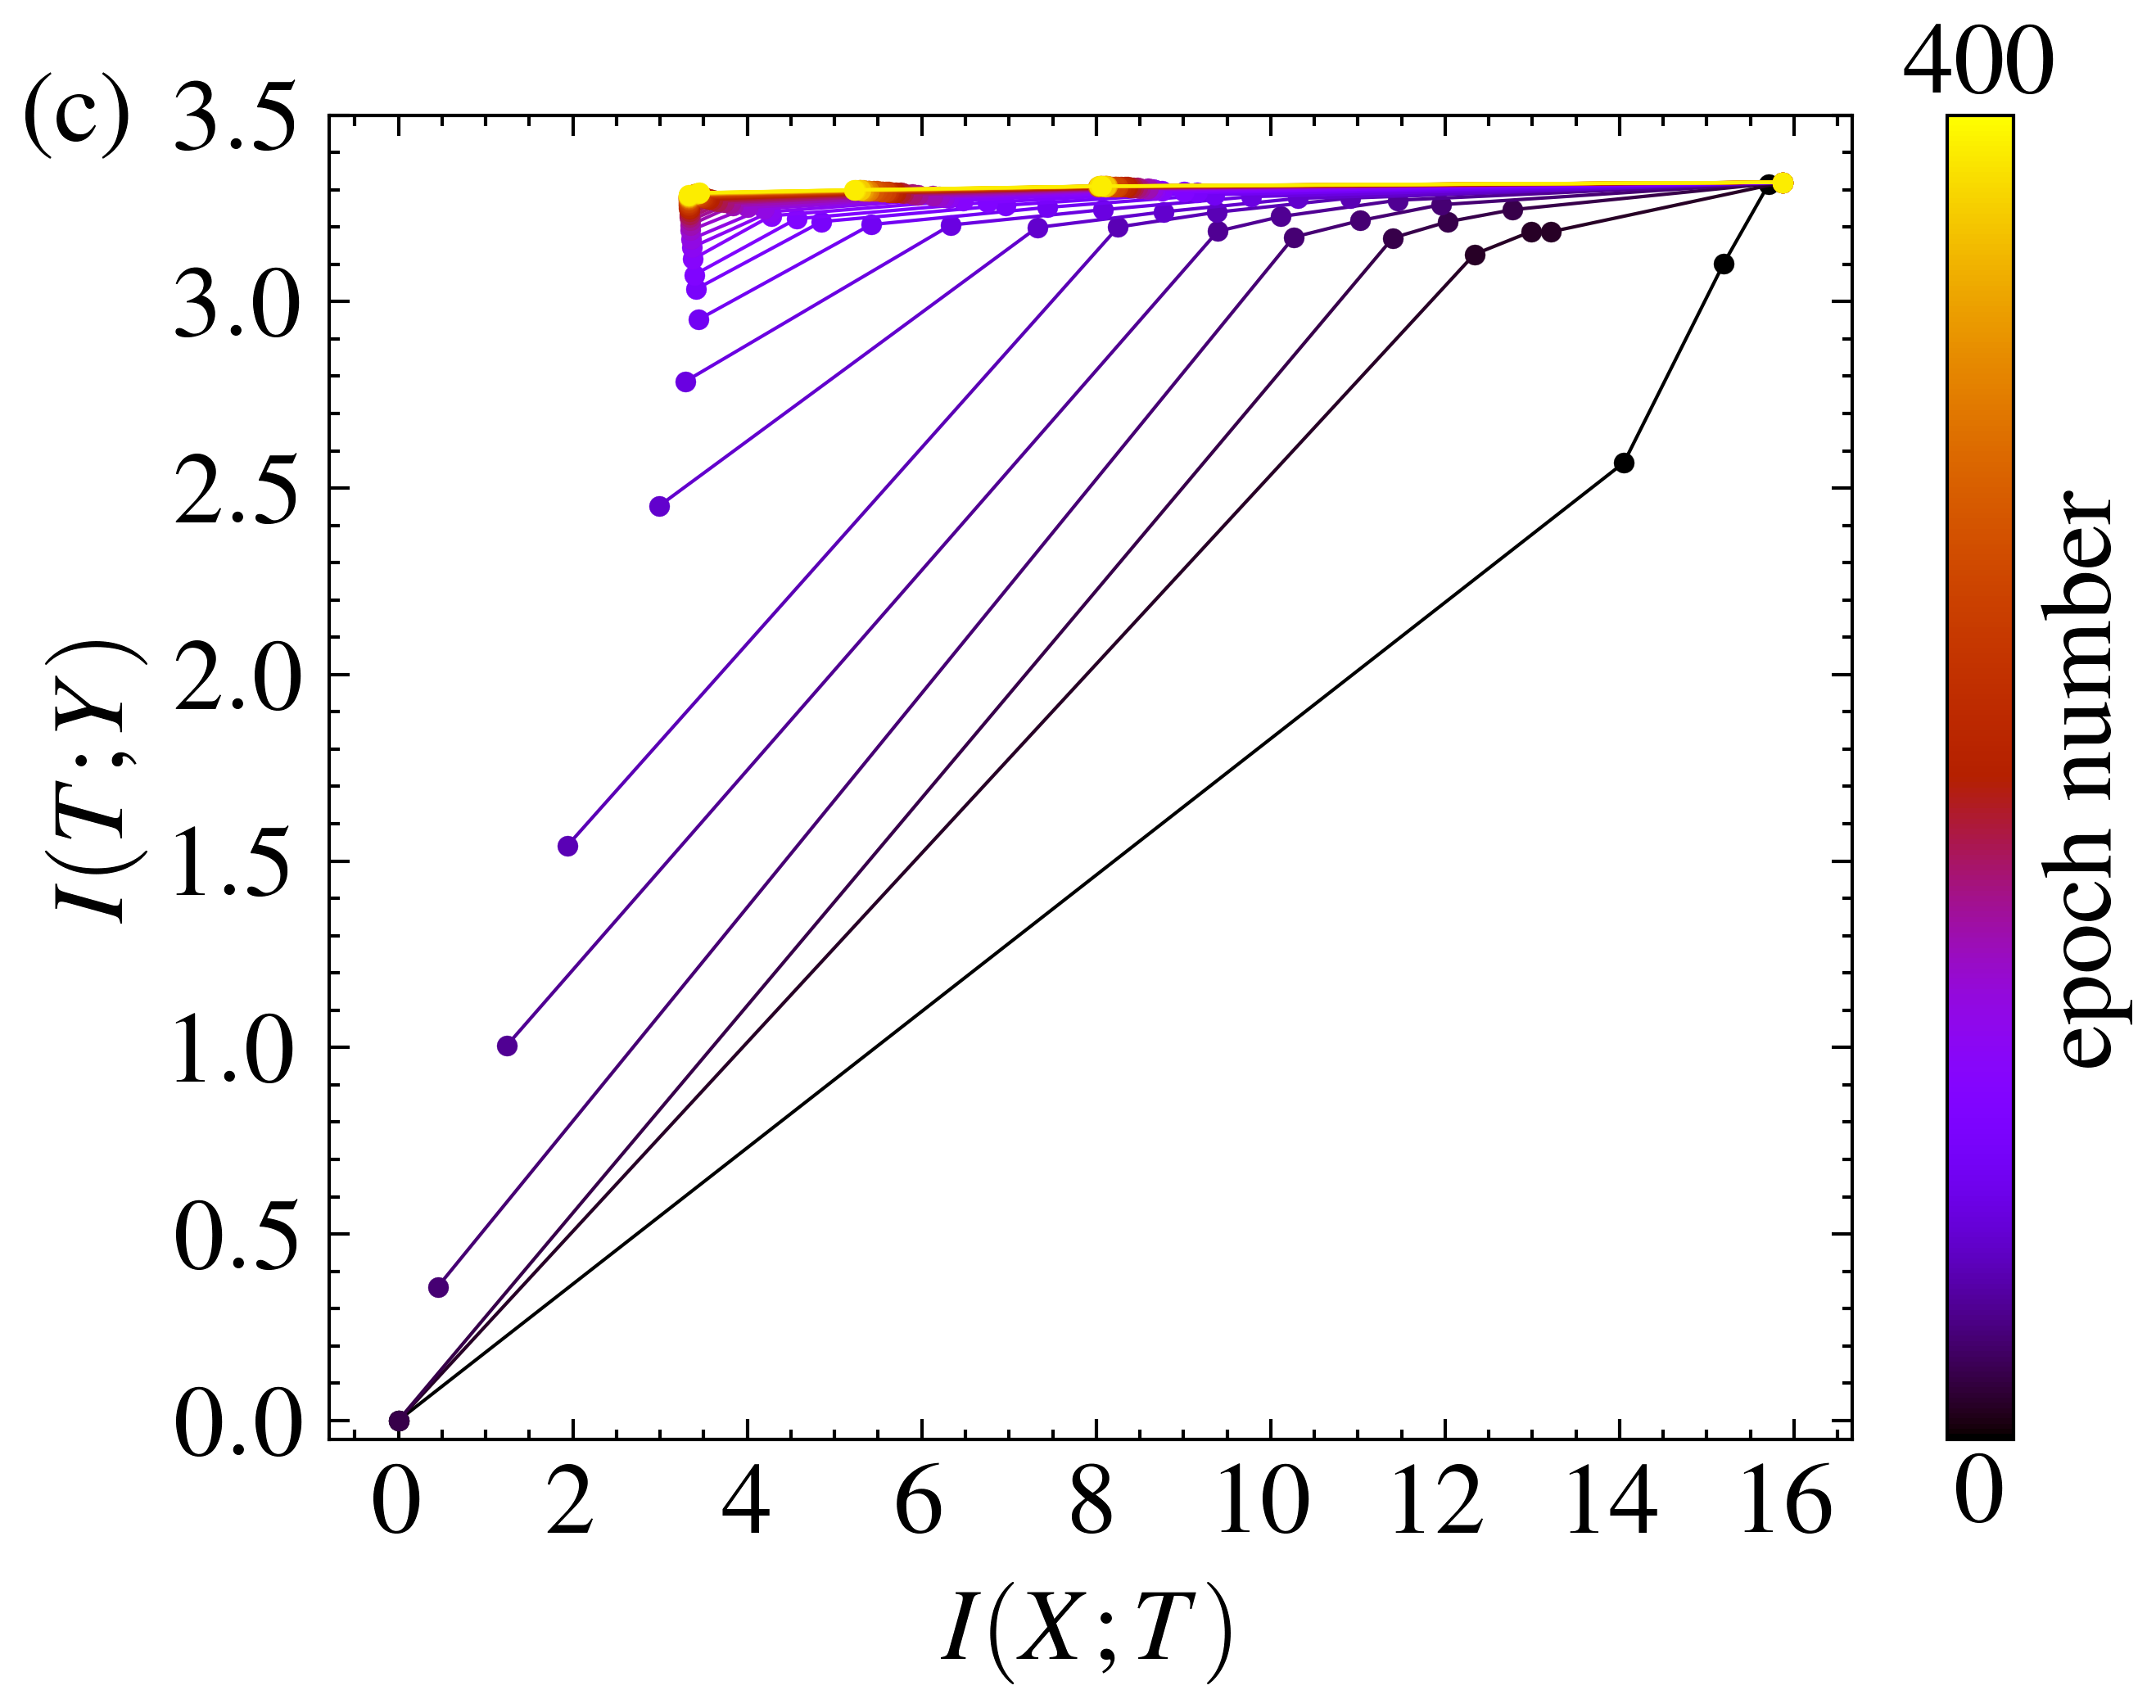

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import scienceplots
plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.style.use(['science', 'ieee'])
mpl.rcParams.update({'font.size': 15})

def plot_information_plane(IXT_array, ITY_array, num_epochs, every_n):
    assert len(IXT_array) == len(ITY_array)

    max_index = len(IXT_array)

    fig, ax = plt.subplots(figsize=(5, 3.5))
    ax.set_xlabel('$I(X;T)$', fontsize=15)
    ax.set_ylabel('$I(T;Y)$', fontsize=15)

    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, num_epochs + 1)]

    for i in range(0, max_index):
        IXT = IXT_array[i, :]
        ITY = ITY_array[i, :]
        ax.plot(IXT, ITY, marker='o', markersize=3, markeredgewidth=0.04,
                linestyle='-', linewidth=0.5, color=colors[i * every_n], zorder=10)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm._A = []

    # 使用ax参数指定颜色条位置
    cbar = plt.colorbar(sm, ax=ax, ticks=[])
    cbar.set_label('epoch number', fontsize=15)
    cbar.ax.tick_params(labelsize=15)
    cbar.ax.text(0.5, -0.01, 0, transform=cbar.ax.transAxes, va='top', ha='center')
    cbar.ax.text(0.5, 1.0, str(num_epochs), transform=cbar.ax.transAxes, va='bottom', ha='center')

    ax.set_xticks([0, 2, 4, 6, 8, 10, 12, 14, 16])
    ax.set_yticks([0, 0.5, 1, 1.5, 2, 2.5, 3.0, 3.5])
    ax.set_ylim(-0.05, 3.5)  # 修改y轴坐标范围
    # Adjust coordinates of text according to the plot area
    ax.text(-0.2, 0.98, '(c)', fontdict={'size': 15, 'color': 'black'}, transform=ax.transAxes)

    fig.savefig('D:/深度学习与信息论/Fig7c.eps', dpi=800)
    plt.show()

IXT_array = np.array(trackingsigma['running_mis_xt']['train'])
ITY_array = np.array(trackingsigma['running_mis_ty']['train'])

plot_information_plane(IXT_array, ITY_array, num_epochs=400, every_n=10)

In [59]:
print(np.array(trackingsigma['running_mis_ty']['train']))

[[ 3.31987093  3.31364008  3.1022664   2.56828108 -0.        ]
 [ 3.31987093  3.18689791  3.18824411  3.12671539 -0.        ]
 [ 3.31987093  3.24628319  3.21382659  3.17071864 -0.        ]
 [ 3.31987093  3.25977982  3.21707938  3.17276628  0.35810911]
 [ 3.31987093  3.27180715  3.22805292  3.18855269  1.00610665]
 [ 3.31987093  3.27754595  3.23961898  3.19983002  1.5415034 ]
 [ 3.31987093  3.27665664  3.2405563   3.19859123  2.45191661]
 [ 3.31987093  3.28137312  3.24628386  3.20524368  2.78616497]
 [ 3.31987093  3.28696757  3.25253695  3.20636879  2.95196678]
 [ 3.31987093  3.29181916  3.25825888  3.21440944  3.03341103]
 [ 3.31987093  3.2940964   3.26597344  3.22212423  3.07192495]
 [ 3.31987093  3.29695279  3.27131141  3.22994875  3.11423974]
 [ 3.31987093  3.29925125  3.27688079  3.24101831  3.14562781]
 [ 3.31987093  3.30111432  3.28030593  3.2491849   3.16759785]
 [ 3.31987093  3.30236025  3.28221405  3.25287071  3.19129288]
 [ 3.31987093  3.30380931  3.28447867  3.25720438  3.20

In [60]:
print(np.array(trackingsigma['running_mis_xt']['train']))

[[15.87267488 15.7060113  15.19285555 14.04949786 -0.        ]
 [15.87267488 13.20754467 12.99074957 12.33422668 -0.        ]
 [15.87267488 12.77142157 12.02461033 11.39936248 -0.        ]
 [15.87267488 11.95158573 11.02434238 10.26351367  0.45044323]
 [15.87267488 11.45308005 10.11701281  9.3926036   1.24605061]
 [15.87267488 10.91188499  9.38028323  8.25011049  1.9386895 ]
 [15.87267488 10.30752025  8.76976644  7.32195008  2.98845554]
 [15.87267488  9.77628392  8.07369018  6.33186789  3.29083448]
 [15.87267488  9.35713271  7.43645722  5.41826045  3.44075007]
 [15.87267488  9.15558658  6.95915941  4.85213634  3.41168937]
 [15.87267488  9.00956168  6.75023437  4.56464626  3.39239032]
 [15.87267488  8.74859328  6.46760405  4.27160239  3.37792509]
 [15.87267488  8.68245849  6.31404085  4.26874519  3.36587508]
 [15.87267488  8.64541358  6.25684843  4.18681504  3.35669745]
 [15.87267488  8.58540099  6.19833182  4.00506702  3.34877306]
 [15.87267488  8.59515304  6.1239688   3.8356087   3.34

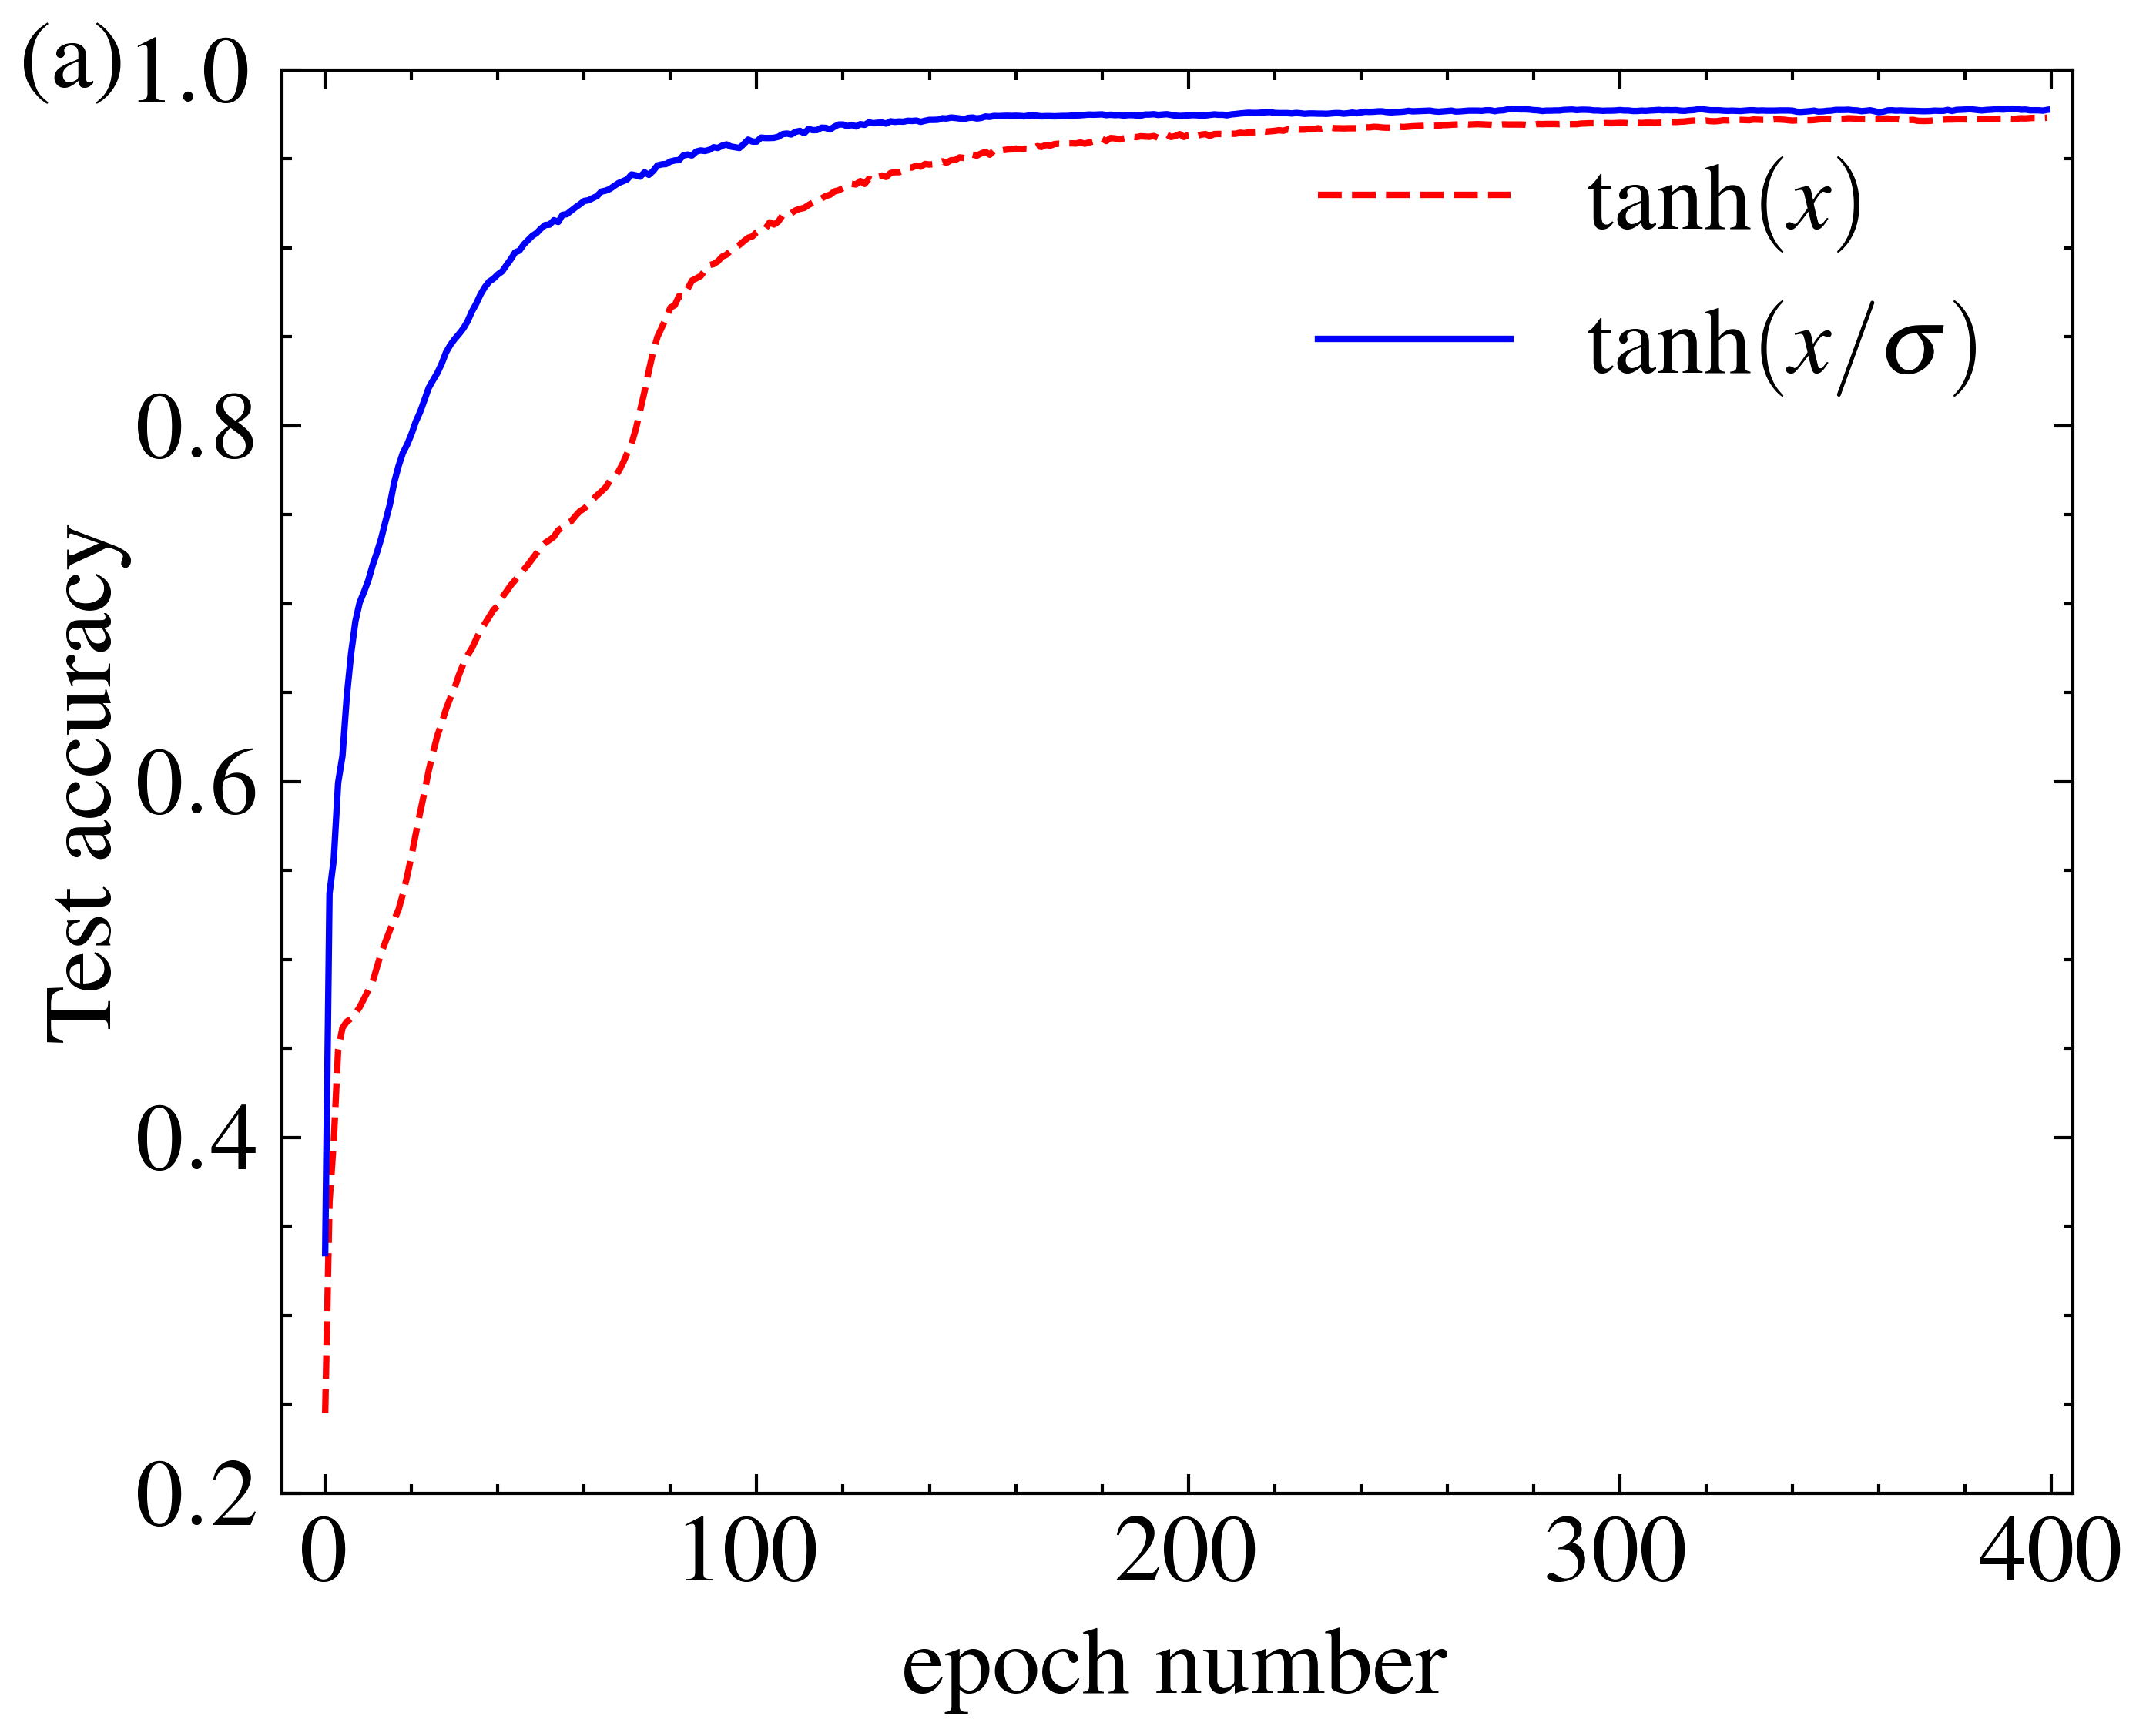

In [70]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots
plt.rcParams ['font.serif'] = ['Times New Roman']
#plt.rcParams['font.family'] = 'STIX General'
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'  # Combine elements
plt.rcParams['text.latex.preamble'] = r'\usepackage{amssymb}'  # Combine elements
plt.style.use(['science','ieee'])
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('epoch number', fontsize=15)
ax.set_ylabel(r"Test accuracy", fontsize=15,labelpad = 1)
ax.set_xlim(-10, 405)
ax.set_ylim(0.2, 1)


numpy_tensor1=np.array(tracking['accuracy']['test'])
numpy_tensor2=np.array(trackingsigma['accuracy']['test'])

# 绘制曲线图
plt.plot(numpy_tensor1, 'r--', lw=1, label=r"${\rm tanh}(x)$")
plt.plot(numpy_tensor2,'b-', lw=1, label=r"${\rm tanh}(x/\sigma)$")

ax.text(-70, 0.99, '(a)',fontdict={'size': 15, 'color':  'black'})
ax.legend(loc='upper right', fontsize=15)
plt.show()

fig.savefig('D:/深度学习与信息论/Fig7a.eps', dpi=800)